# Cerno Project

In [24]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow==2.5.0
!pip install librosa

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from datetime import datetime
import librosa
import librosa.display


from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from pandas.plotting import scatter_matrix


In [2]:
from numpy.core.numeric import normalize_axis_tuple
def sliding_window_view(x, window_shape, axis=None, *,
                        subok=False, writeable=False):
    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return np.lib.stride_tricks.as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)


**Data Cleaning**

In [3]:
data_dir = 'C:/Users/Thomas/OneDrive/Desktop/DataPaper/'

users = [user for user in os.listdir(data_dir) if user.startswith('user_')]
print(users)

for user in users:
    
    path_sleep = os.path.join(data_dir, user, 'sleep.csv')
    # Index (unnamed), 'In Bed Date', 'In Bed Time', 'Out Bed Date', 'Out Bed Time'
    df_sleep = pd.read_csv(path_sleep, index_col=0, usecols=[0,1,2,3,4])
    display(df_sleep)
    
    path_signals = os.path.join(data_dir, user, 'Actigraph.csv')
    # Index (unnamed), 'Axis1', 'Axis2', 'Axis3', 'Steps', 'HR'
    df_signals = pd.read_csv(path_signals, index_col=[0], usecols=[0,1,2,3,4,5])
    display(df_signals)
   
    # Data cleaning
    if df_sleep.empty or df_sleep.isnull().any().any() or df_signals.empty or df_signals.isnull().any().any():
        print(user)
        users.remove(user)


['user_1', 'user_10', 'user_11', 'user_12', 'user_13', 'user_14', 'user_15', 'user_16', 'user_17', 'user_18', 'user_19', 'user_2', 'user_20', 'user_21', 'user_22', 'user_3', 'user_4', 'user_5', 'user_6', 'user_7', 'user_8', 'user_9']


In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:46             2        03:31
1            2       03:57             2        07:30

Axis1  Axis2  Axis3  Steps     HR
82         0      0      0      0   68.0
83        11      4      7      1   68.0
84         0     21     10      0   68.0
85         0      1     24      0   68.0
86        34     14     63      1  154.0
...      ...    ...    ...    ...    ...
84985     31      0     31      1  119.0
84986     34      0     17      0  121.0
84987      7      4      3      0  123.0
84988     12     50     13      0  124.0
84995     84     27    237      1  125.0

[67936 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       02:40             2        08:09

Axis1  Axis2  Axis3  Steps     HR
250        0      0      8      0  171.0
251       43     43     64      0  171.0
252       16      2     53      1  171.0
285        0      0      0      0   84.0
286        0      0      0      0   84.0
...      ...    ...    ...    ...    ...
87584     15     22     29      0  100.0
87585    108    106     55      1  100.0
87586     35     60    100      1  100.0
87587     93     63    145      1  100.0
87588    152    196     74      0  100.0

[58616 rows x 5 columns]

Empty DataFrame
Columns: [In Bed Date, In Bed Time, Out Bed Date, Out Bed Time]
Index: []

Axis1  Axis2  Axis3  Steps     HR
39        53     61    106      1  213.0
40        34      0     21      0  213.0
41         0      0     35      0  213.0
42         0      0      4      0  213.0
43         0      0      0      0  213.0
...      ...    ...    ...    ...    ...
87085     67     31     76      0   91.0
87086     75    113     80      0   91.0
87087     45    101     66      1   91.0
87088    188    166    271      0   91.0
87089     14    198    159      0   91.0

[68362 rows x 5 columns]

user_11


In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            1       23:41             1        05:04

Axis1  Axis2  Axis3  Steps    HR
8         55     39    133      0  93.0
9          0      0     33      0  93.0
28         0      0      0      0  15.0
29         4      1      7      1  94.0
30        58     42     31      1  94.0
...      ...    ...    ...    ...   ...
84208      0      0      0      0  90.0
84209      0      0      0      0  90.0
84210      0      0      0      0  90.0
84211      0      0      0      0  90.0
84212      0      0      0      0  90.0

[67350 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:08             2        07:00

Axis1  Axis2  Axis3  Steps     HR
129        0      0      0      0  100.0
130        0      0      0      0  101.0
131        0      0      0      0  101.0
132        0      0      0      0  101.0
133        0      0      0      0  101.0
...      ...    ...    ...    ...    ...
85327      0      0      0      0  122.0
85328      0      0      0      0  122.0
85329      0      0      0      0  122.0
85330      0      0      0      0  122.0
85331      0      0      0      0  122.0

[67995 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       01:15             2        05:39

Axis1  Axis2  Axis3  Steps     HR
28        99     32     94      0  207.0
29         2     54    131      1  207.0
30       114     95     68      0  207.0
31        57     30     88      0  207.0
32        72    105    112      1  207.0
...      ...    ...    ...    ...    ...
91795      0      0      0      0  145.0
91796      0      0      0      0  145.0
91797      0      0      0      0  146.0
91798      0      0      0      0  152.0
91799      0      0      0      0  157.0

[71045 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:22             2        07:58

Axis1  Axis2  Axis3  Steps     HR
218        2     35     39      0   30.0
219       31    119     68      1   30.0
220       27     46     73      0   30.0
221       14     48     30      0   30.0
222       19     73     10      1   30.0
...      ...    ...    ...    ...    ...
92395      0      0      0      0  126.0
92396      0      0      0      0  122.0
92397      0      0      0      0  121.0
92398      0      0      0      0  118.0
92399      0      0      0      0  122.0

[69850 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:44             2        06:36

Axis1  Axis2  Axis3  Steps     HR
10        14      0     58      1  228.0
11         0      0     19      0  215.0
12        64    116     50      0  215.0
13        10    208    133      1  215.0
14        36     56     78      0  215.0
...      ...    ...    ...    ...    ...
91823      0      0      0      0  149.0
91824      0      0      0      0  151.0
91825      0      0      0      0  151.0
91826      0      0      0      0  153.0
91827      0      0      0      0  152.0

[68351 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:55             2        06:53

Axis1  Axis2  Axis3  Steps     HR
90        83      0     26      0  227.0
91        83     64     26      0  227.0
92        45     12     22      1  227.0
93         8      0      4      0  227.0
94         0      0      0      0  180.0
...      ...    ...    ...    ...    ...
86374      0      0      0      0   87.0
86375      0      0      0      0   87.0
86376      0      0      0      0   87.0
86377      0      0      0      0   87.0
86378      0      0      0      0   87.0

[65911 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            1       22:56             1        06:35

Axis1  Axis2  Axis3  Steps     HR
69        87    257    110      1   79.0
70        17    211     89      0   79.0
71        28     55      0      1   79.0
72         0     23      0      0   77.0
73         0      0      0      0   74.0
...      ...    ...    ...    ...    ...
85575      0      0      0      0  100.0
85576      0      0      0      0  100.0
85577      0      0      0      0  100.0
85578      0      0      0      0  100.0
85579      0      0      0      0  100.0

[68326 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:50             2        06:22

Axis1  Axis2  Axis3  Steps     HR
201       19    120     72      1  136.0
202       89    188    113      1  136.0
203      107     30     94      1   94.0
204      127     65    120      1   94.0
205       68    185     65      1   94.0
...      ...    ...    ...    ...    ...
85509     15    104     71      1   86.0
85510      0     22     20      0   86.0
85511      0      0      0      0   86.0
85512      0      0      0      0   86.0
85513      0      0      0      0   86.0

[60862 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       01:03             2        08:19

Axis1  Axis2  Axis3  Steps     HR
23       275     86     67      1   72.0
24        93    112     45      1   69.0
25        69     39     61      0   68.0
26        66     86    140      1   68.0
27        50     44     38      0   69.0
...      ...    ...    ...    ...    ...
84913      0      0      0      0  102.0
84914      0      0      0      0  102.0
84915      0      0      0      0  102.0
84916      0      0      0      0  102.0
84917      0      0      0      0  102.0

[64740 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       02:19             2        07:16

Axis1  Axis2  Axis3  Steps     HR
23        19      0      0      0   98.0
24        49      0      5      1   97.0
25       108     34      3      0  153.0
26        45      5      0      1  166.0
27        99      0     46      0  166.0
...      ...    ...    ...    ...    ...
83208      2      0      9      0  149.0
83209      4      0     24      0  149.0
83210     13      0     42      1  149.0
83211      0      5      0      0  149.0
83212      0      0      0      0  142.0

[67186 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       01:06             2        07:04

Axis1  Axis2  Axis3  Steps    HR
9          0      0      0      0  70.0
10         0      0      0      0  71.0
11         0      0      0      0  71.0
12         0      0      0      0  71.0
13         0      0      0      0  71.0
...      ...    ...    ...    ...   ...
84411     90    115     80      0  72.0
84412     33     49     28      1  72.0
84413     32     25     34      0  72.0
84414     59     28    188      1  72.0
84415     70     22    158      0  72.0

[67874 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            1       22:29             1        05:52

Axis1  Axis2  Axis3  Steps    HR
251       14     13    134      0  93.0
252       34      0     59      1  93.0
253       65     15    173      0  94.0
254       35     17    110      1  94.0
255       62     14    191      0  93.0
...      ...    ...    ...    ...   ...
89315      0      0      0      0  88.0
89316      0      0      0      0  88.0
89317      0      0      0      0  88.0
89318      0      0      0      0  89.0
89319      0      0      0      0  89.0

[67772 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:57             2        07:10

Axis1  Axis2  Axis3  Steps    HR
113       77    140     64      1  71.0
114       65    137     48      1  73.0
115       78     51     34      2  73.0
116      138    198     21      0  73.0
117       36     50     21      1  73.0
...      ...    ...    ...    ...   ...
88234      0      0      0      0  74.0
88235      0      0      0      0  74.0
88236      0      0      0      0  73.0
88237      0      0      0      0  74.0
88238      0      0      0      0  74.0

[64796 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            1       23:56             1        06:42

Axis1  Axis2  Axis3  Steps     HR
130       15     84     66      1  228.0
131       39    101     81      0  228.0
132       55     99     28      0   81.0
133       46    103     84      0   86.0
134       36     14     24      1  104.0
...      ...    ...    ...    ...    ...
88562      0      0      0      0   94.0
88563      0      0      0      0   94.0
88564      0      0      0      0   94.0
88565      0      0      0      0   93.0
88566      0      0      0      0   93.0

[65054 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       02:27             2        09:02

Axis1  Axis2  Axis3  Steps     HR
180       38      1     95      0   68.0
181       15     11     36      0   67.0
182       21     17     63      2   67.0
183       39      0     48      0   67.0
184       28      0     22      1   67.0
...      ...    ...    ...    ...    ...
85944      0      0      0      0  122.0
85945      0      0      0      0  122.0
85946    164     30     59      1  122.0
85947    102     26     53      1  122.0
85948    168    191     80      1  122.0

[67400 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:28             2        08:02

Axis1  Axis2  Axis3  Steps    HR
145       49      0     74      0  78.0
146      173      8    167      0  77.0
147      211     51    276      1  77.0
148      107     93     86      1  76.0
149      258    151    287      2  75.0
...      ...    ...    ...    ...   ...
86876      0      0      0      0  88.0
86877      0      0      0      0  87.0
86878      0      0      0      0  87.0
86879      0      0      0      0  87.0
86880      0      0      0      0  87.0

[68714 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:17             2        07:13

Axis1  Axis2  Axis3  Steps    HR
189       37     23     49      0  92.0
190        3     24     94      1  90.0
191       30      4    120      1  90.0
192       33      6    113      1  89.0
193       14      1     80      1  88.0
...      ...    ...    ...    ...   ...
83891      0      0      0      0  72.0
83892      0      0      0      0  72.0
83893      0      0      0      0  72.0
83894      0      0      0      0  72.0
83895      0      0      0      0  72.0

[61678 rows x 5 columns]

In Bed Date In Bed Time  Out Bed Date Out Bed Time
0            2       00:30             2        11:00

Axis1  Axis2  Axis3  Steps     HR
221       95    124     31      1  126.0
222       49     40     16      0  109.0
223       44     27     20      0  106.0
224        8      2     11      1  101.0
225       16     29     16      1   99.0
...      ...    ...    ...    ...    ...
84083      0      0      0      0   85.0
84090      0      0      0      0   90.0
84091      0      0      0      0   90.0
84092      0      0      0      0   90.0
84093      0      0      0      0   90.0

[64121 rows x 5 columns]

In [4]:
len(users)

21

**Splitting users in training, validation and testing**

In [5]:
train_users, test_users = train_test_split(users, test_size=0.4, random_state=42)
val_users, test_users = train_test_split(test_users, test_size=0.5, random_state=42)
print('Training users: %s, Validation users: %s, Testing users: %s' % (len(train_users), len(val_users), len(test_users)))
print(train_users)
print(val_users)
print(test_users)


# train_users, test_users = train_test_split(users, test_size=0.2, random_state=42)
# print('Training users: %s, Testing users: %s' % (len(train_users), len(test_users)))
# print(train_users)
# print(test_users)



Training users: 12, Validation users: 4, Testing users: 5
['user_5', 'user_22', 'user_12', 'user_19', 'user_9', 'user_14', 'user_21', 'user_17', 'user_2', 'user_3', 'user_8', 'user_16']
['user_4', 'user_18', 'user_10', 'user_20']
['user_13', 'user_6', 'user_15', 'user_1', 'user_7']


**Visualising data and statistics**

Axis1  Axis2  Axis3  Steps     HR  Inclinometer Standing  \
130       15     84     66      1  228.0                      1   
131       39    101     81      0  228.0                      1   
132       55     99     28      0   81.0                      1   
133       46    103     84      0   86.0                      1   
134       36     14     24      1  104.0                      1   
...      ...    ...    ...    ...    ...                    ...   
88562      0      0      0      0   94.0                      0   
88563      0      0      0      0   94.0                      0   
88564      0      0      0      0   94.0                      0   
88565      0      0      0      0   93.0                      0   
88566      0      0      0      0   93.0                      0   

       Inclinometer Sitting  Inclinometer Lying  
130                       0                   0  
131                       0                   0  
132                       0                   0  
133                       0                   0  
134                       0                   0  
...                     ...                 ...  
88562                     0                   1  
88563                     0                   1  
88564                     0                   1  
88565                     0                   1  
88566                     0                   1  

[65054 rows x 8 columns]

Axis1     Axis2     Axis3     Steps        HR  \
Axis1                  1.000000  0.722756  0.697978  0.528078  0.415611   
Axis2                  0.722756  1.000000  0.655488  0.515148  0.439305   
Axis3                  0.697978  0.655488  1.000000  0.521395  0.419623   
Steps                  0.528078  0.515148  0.521395  1.000000  0.416283   
HR                     0.415611  0.439305  0.419623  0.416283  1.000000   
Inclinometer Standing  0.639784  0.558339  0.622173  0.587545  0.503363   
Inclinometer Sitting  -0.285140 -0.242360 -0.259928 -0.258359 -0.135982   
Inclinometer Lying    -0.122326 -0.105350 -0.118647 -0.106764  0.023039   

                       Inclinometer Standing  Inclinometer Sitting  \
Axis1                               0.639784             -0.285140   
Axis2                               0.558339             -0.242360   
Axis3                               0.622173             -0.259928   
Steps                               0.587545             -0.258359   
HR                                  0.503363             -0.135982   
Inclinometer Standing               1.000000             -0.446618   
Inclinometer Sitting               -0.446618              1.000000   
Inclinometer Lying                 -0.193096             -0.277637   

                       Inclinometer Lying  
Axis1                           -0.122326  
Axis2                           -0.105350  
Axis3                           -0.118647  
Steps                           -0.106764  
HR                               0.023039  
Inclinometer Standing           -0.193096  
Inclinometer Sitting            -0.277637  
Inclinometer Lying               1.000000

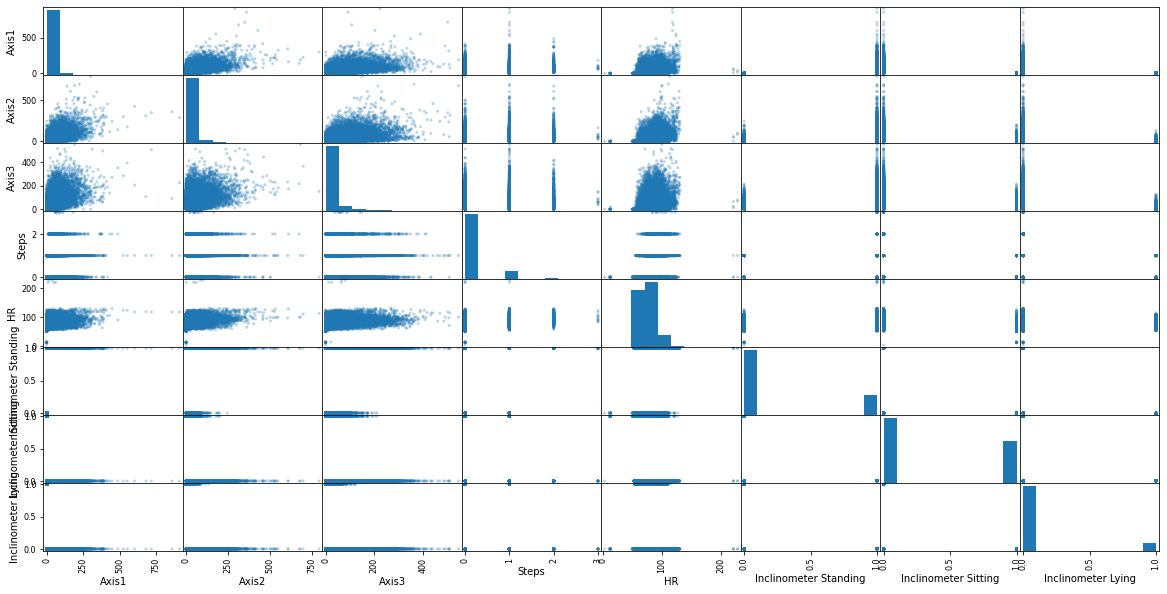

In [6]:
example = os.path.join(data_dir, train_users[0],'Actigraph.csv')
example = pd.read_csv(example, index_col=0, usecols=[0,1,2,3,4,5,7,8,9])
display(example)

scatter_matrix(example[example.columns], figsize=(20,10), alpha=0.3)
display(example.corr())



**TRANSFORMATIONS**

In [7]:

class MissingDataValues(BaseEstimator, TransformerMixin):
    def __init__(self,):
        self.column_names=['Axis1','Axis2','Axis3','Steps','HR','Inclinometer Standing',
                          'Inclinometer Sitting', 'Inclinometer Lying']
    def fit(self,X,y=None):
        return self
    def transform(self, X):
        missing_index = [i for i in range(X.index.values[0], max(X.index.values)) if i not in X.index.values]
        df_missing = pd.DataFrame(np.nan, index=missing_index, 
                          columns=self.column_names)
        
        df_complete = pd.concat([df_missing, X]).sort_index()
        df_complete.ffill(inplace=True) # Propogate last non-nan observation forward
        return df_complete


# missing_data_values = MissingDataValues()
# df = missing_data_values.fit_transform(x)
# df


In [8]:
class SignalSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, window_size):
        self.window_size = window_size
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.rolling(window=self.window_size)
        X = X.mean()
        X.dropna(inplace=True)
        return X
class LabelSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, window_size):
        self.window_size = window_size
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.rolling(window=self.window_size)
        X = X.apply(lambda x: x.mode()[0])
        X.dropna(inplace=True)
        return X

In [9]:
class ComputeSleepLabels(BaseEstimator, TransformerMixin):
    def __init__(self, signal_length, signal_start_timestamp):
        self.signal_length = signal_length
        self.signal_start_timestamp = signal_start_timestamp
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        df_labels = pd.DataFrame(np.zeros(shape=(self.signal_length,1)), columns=['Bed Time'])
        
        for index, row in X.iterrows():
            bed_start = str(row['In Bed Date']) + ':' + row['In Bed Time']

            bed_duration = row['Total Minutes in Bed'] * 60

            bed_start_seconds =  datetime.strptime(bed_start, '%d:%H:%M') \
                                - datetime.strptime(self.signal_start_timestamp, '%d:%H:%M:%S')
            bed_start_seconds = int(bed_start_seconds.total_seconds() + 1)

#             print(bed_start_seconds, bed_duration)
            df_labels.iloc[bed_start_seconds:bed_start_seconds+bed_duration, 0] = 1
        
        return df_labels
    
    

In [10]:
class SlidingWindow(BaseEstimator, TransformerMixin):
    def __init__(self,window_size=30, stride_size=15):
        self.window_size = window_size
        self.stride_size = stride_size
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        windows = sliding_window_view(
            x=X,
            window_shape=self.window_size ,
            axis=0,
        )[::self.stride_size, ::]
        return windows
    
    
# sliding_window = SlidingWindow()
# x = sliding_window.fit_transform(df_train_x)

In [11]:
class LabelWindows(BaseEstimator, TransformerMixin):
    def __init__(self,):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = np.array([1 if np.sum(X[i])/X.shape[1] >=0.5  else 0 for i in range(X.shape[0])])
        return X

**Compute scaler information from training data**

In [362]:
missing_data_values = MissingDataValues()
df_train_x_list = []

for user in train_users:
    print(user)
    df_train_x = os.path.join(data_dir, user,'Actigraph.csv')
    df_train_x = pd.read_csv(df_train_x, index_col=0, usecols=[0,1,2,3,4,5,7,8,9])

    df_train_x = missing_data_values.fit_transform(df_train_x)
    df_train_x = df_train_x.reset_index(drop=True)
    df_train_x_list.append(df_train_x)
    
df_train_x_overall = pd.concat(df_train_x_list)

standard_scaler = StandardScaler()
standard_scaler = standard_scaler.fit(df_train_x_overall)
standard_scaler_scale, standard_scaler_mean, standard_scaler_var = \
standard_scaler.scale_, standard_scaler.mean_, standard_scaler.var_

print(standard_scaler_scale, standard_scaler_mean, standard_scaler_var)

standard_scaler_scale = np.array([38.98531074,42.73927114,40.47020352,0.44570045,20.08760831,0.46590236,0.46370771,0.33880756])
standard_scaler_mean = np.array([16.45840671,16.26198067,18.35418061,0.18630539,75.20680667,0.31852,0.31298354,0.13229164])
standard_scaler_var = np.array([1.51985445e+03,1.82664530e+03,1.63783737e+03,1.98648895e-01,4.03512008e+02,2.17065010e-01,2.15024843e-01,1.14790565e-01])


# standard_scaler_scale = np.array([37.83007858,41.57850584,39.63476366,0.43680563,20.65314754,0.46698684,0.46383747,0.34662907])
# standard_scaler_mean = np.array([16.11405758,16.13150557,18.00845563,0.18146384,76.11656304,0.32132909,0.31330559,0.13965533])
# standard_scaler_var = np.array([1.43111485e+03,1.72877215e+03,1.57091449e+03,1.90799158e-01,4.26552503e+02,2.18076707e-01,2.15145197e-01,1.20151715e-01])


user_5
user_22
user_12
user_19
user_9
user_14
user_21
user_17
user_2
user_3
user_8
user_16
[38.98531074 42.73927114 40.47020352  0.44570045 20.08760831  0.46590236
  0.46370771  0.33880756] [16.45840671 16.26198067 18.35418061  0.18630539 75.20680667  0.31852
  0.31298354  0.13229164] [1.51985445e+03 1.82664530e+03 1.63783737e+03 1.98648895e-01
 4.03512008e+02 2.17065010e-01 2.15024843e-01 1.14790565e-01]


In [12]:
class StandardizeData(BaseEstimator, TransformerMixin):
    def __init__(self, standard_scaler_scale, standard_scaler_mean, standard_scaler_var):
        self.standard_scaler_scale = standard_scaler_scale
        self.standard_scaler_mean = standard_scaler_mean
        self.standard_scaler_var = standard_scaler_var
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        standard_scaler = StandardScaler()
        standard_scaler.scale_ = self.standard_scaler_scale
        standard_scaler.mean_ = self.standard_scaler_mean 
        standard_scaler.var_ = self.standard_scaler_var
        
        X = standard_scaler.transform(X.values)
        return X

standard_scaler_scale = np.array([38.98531074,42.73927114,40.47020352,0.44570045,20.08760831,0.46590236,0.46370771,0.33880756])
standard_scaler_mean = np.array([16.45840671,16.26198067,18.35418061,0.18630539,75.20680667,0.31852,0.31298354,0.13229164])
standard_scaler_var = np.array([1.51985445e+03,1.82664530e+03,1.63783737e+03,1.98648895e-01,4.03512008e+02,2.17065010e-01,2.15024843e-01,1.14790565e-01])

# standard_scaler_scale = np.array([37.83007858,41.57850584,39.63476366,0.43680563,20.65314754,0.46698684,0.46383747,0.34662907])
# standard_scaler_mean = np.array([16.11405758,16.13150557,18.00845563,0.18146384,76.11656304,0.32132909,0.31330559,0.13965533])
# standard_scaler_var = np.array([1.43111485e+03,1.72877215e+03,1.57091449e+03,1.90799158e-01,4.26552503e+02,2.18076707e-01,2.15145197e-01,1.20151715e-01])



**Preprocessing training**

In [13]:


def preprocess_data(users, is_test=False):
    print(users)
    x_list = []
    y_list = []
    
    if is_test:
        window_size = 30
        stride_size = 30
    else:
        window_size = 30
        stride_size = 15
        
    sequence_size = 30
    
        
    x_pipeline = Pipeline([
        ('missing_data_values', MissingDataValues()),
        ('signal_smoothing', SignalSmoothing(window_size)),
        ('standardize_data', StandardizeData(standard_scaler_scale, standard_scaler_mean, standard_scaler_var)),
        ('sliding_window_frames', SlidingWindow(window_size = window_size, stride_size = stride_size)),
        ('sliding_window_sequences', SlidingWindow(window_size = sequence_size, stride_size = sequence_size)),
    ])

    for user in users:
        print(user)

        # x data processing
        df_x = os.path.join(data_dir, user,'Actigraph.csv')
        df_x = pd.read_csv(df_x, index_col=0, usecols=[0,1,2,3,4,5,7,8,9])
        x = x_pipeline.fit_transform(df_x)
        x = np.swapaxes(x, 1, 3)
    
        # y labels processing
        # Signal length and starting timestamp
        df_signal = pd.read_csv(os.path.join(data_dir, user, 'Actigraph.csv'), usecols=[0,11,12])
        signal_length = df_signal.iloc[:,0].max() - df_signal.iloc[:,0].min() + 1
        signal_start_timestamp = str(df_signal.iloc[0, 1]) + ':' \
                                + df_signal.iloc[0, 2]

        # Sleep diary (y data)
        df_y = os.path.join(data_dir, user, 'sleep.csv')
        df_y = pd.read_csv(df_y, usecols=[1,2,9])


        y_pipeline = Pipeline([
            ('compute_sleep_labels', ComputeSleepLabels(signal_length = signal_length, signal_start_timestamp = signal_start_timestamp)),
            ('label_smoothing', LabelSmoothing(window_size)),
            ('sliding_window_frames', SlidingWindow(window_size = window_size, stride_size = stride_size)),
            ('label_windows', LabelWindows()),      
            ('sliding_window_sequences', SlidingWindow(window_size = sequence_size, stride_size = sequence_size)),

            
        ])

        y = y_pipeline.fit_transform(df_y)
        
        print(x.shape)
        print(y.shape)
             
        
        
        x_list.append(x)
        y_list.append(y)


#     x_overall = np.vstack(x_list)
#     y_overall = np.hstack(y_list)

    x_overall = np.vstack(x_list)
    y_overall = np.vstack(y_list)

    display(x_overall.shape)
    display(y_overall.shape)
    
    return x_overall, y_overall

train_x, train_y = preprocess_data(train_users)
val_x, val_y = preprocess_data(val_users)
test_x, test_y = preprocess_data(test_users, is_test=True)


['user_5', 'user_22', 'user_12', 'user_19', 'user_9', 'user_14', 'user_21', 'user_17', 'user_2', 'user_3', 'user_8', 'user_16']
user_5
(196, 30, 30, 8)
(196, 30)
user_22
(187, 30, 30, 8)
(187, 30)
user_12
(190, 30, 30, 8)
(190, 30)
user_19
(189, 30, 30, 8)
(189, 30)
user_9
(186, 30, 30, 8)
(186, 30)
user_14
(189, 30, 30, 8)
(189, 30)
user_21
(184, 30, 30, 8)
(184, 30)
user_17
(203, 30, 30, 8)
(203, 30)
user_2
(189, 30, 30, 8)
(189, 30)
user_3
(197, 30, 30, 8)
(197, 30)
user_8
(185, 30, 30, 8)
(185, 30)
user_16
(204, 30, 30, 8)
(204, 30)


(2299, 30, 30, 8)

(2299, 30)

['user_4', 'user_18', 'user_10', 'user_20']
user_4
(195, 30, 30, 8)
(195, 30)
user_18
(191, 30, 30, 8)
(191, 30)
user_10
(193, 30, 30, 8)
(193, 30)
user_20
(188, 30, 30, 8)
(188, 30)


(767, 30, 30, 8)

(767, 30)

['user_13', 'user_6', 'user_15', 'user_1', 'user_7']
user_13
(93, 30, 30, 8)
(93, 30)
user_6
(95, 30, 30, 8)
(95, 30)
user_15
(101, 30, 30, 8)
(101, 30)
user_1
(94, 30, 30, 8)
(94, 30)
user_7
(96, 30, 30, 8)
(96, 30)


(479, 30, 30, 8)

(479, 30)

In [14]:
train_x.shape, train_y.shape

((2299, 30, 30, 8), (2299, 30))

Example visualization without smoothing 

Example visualization without smoothing


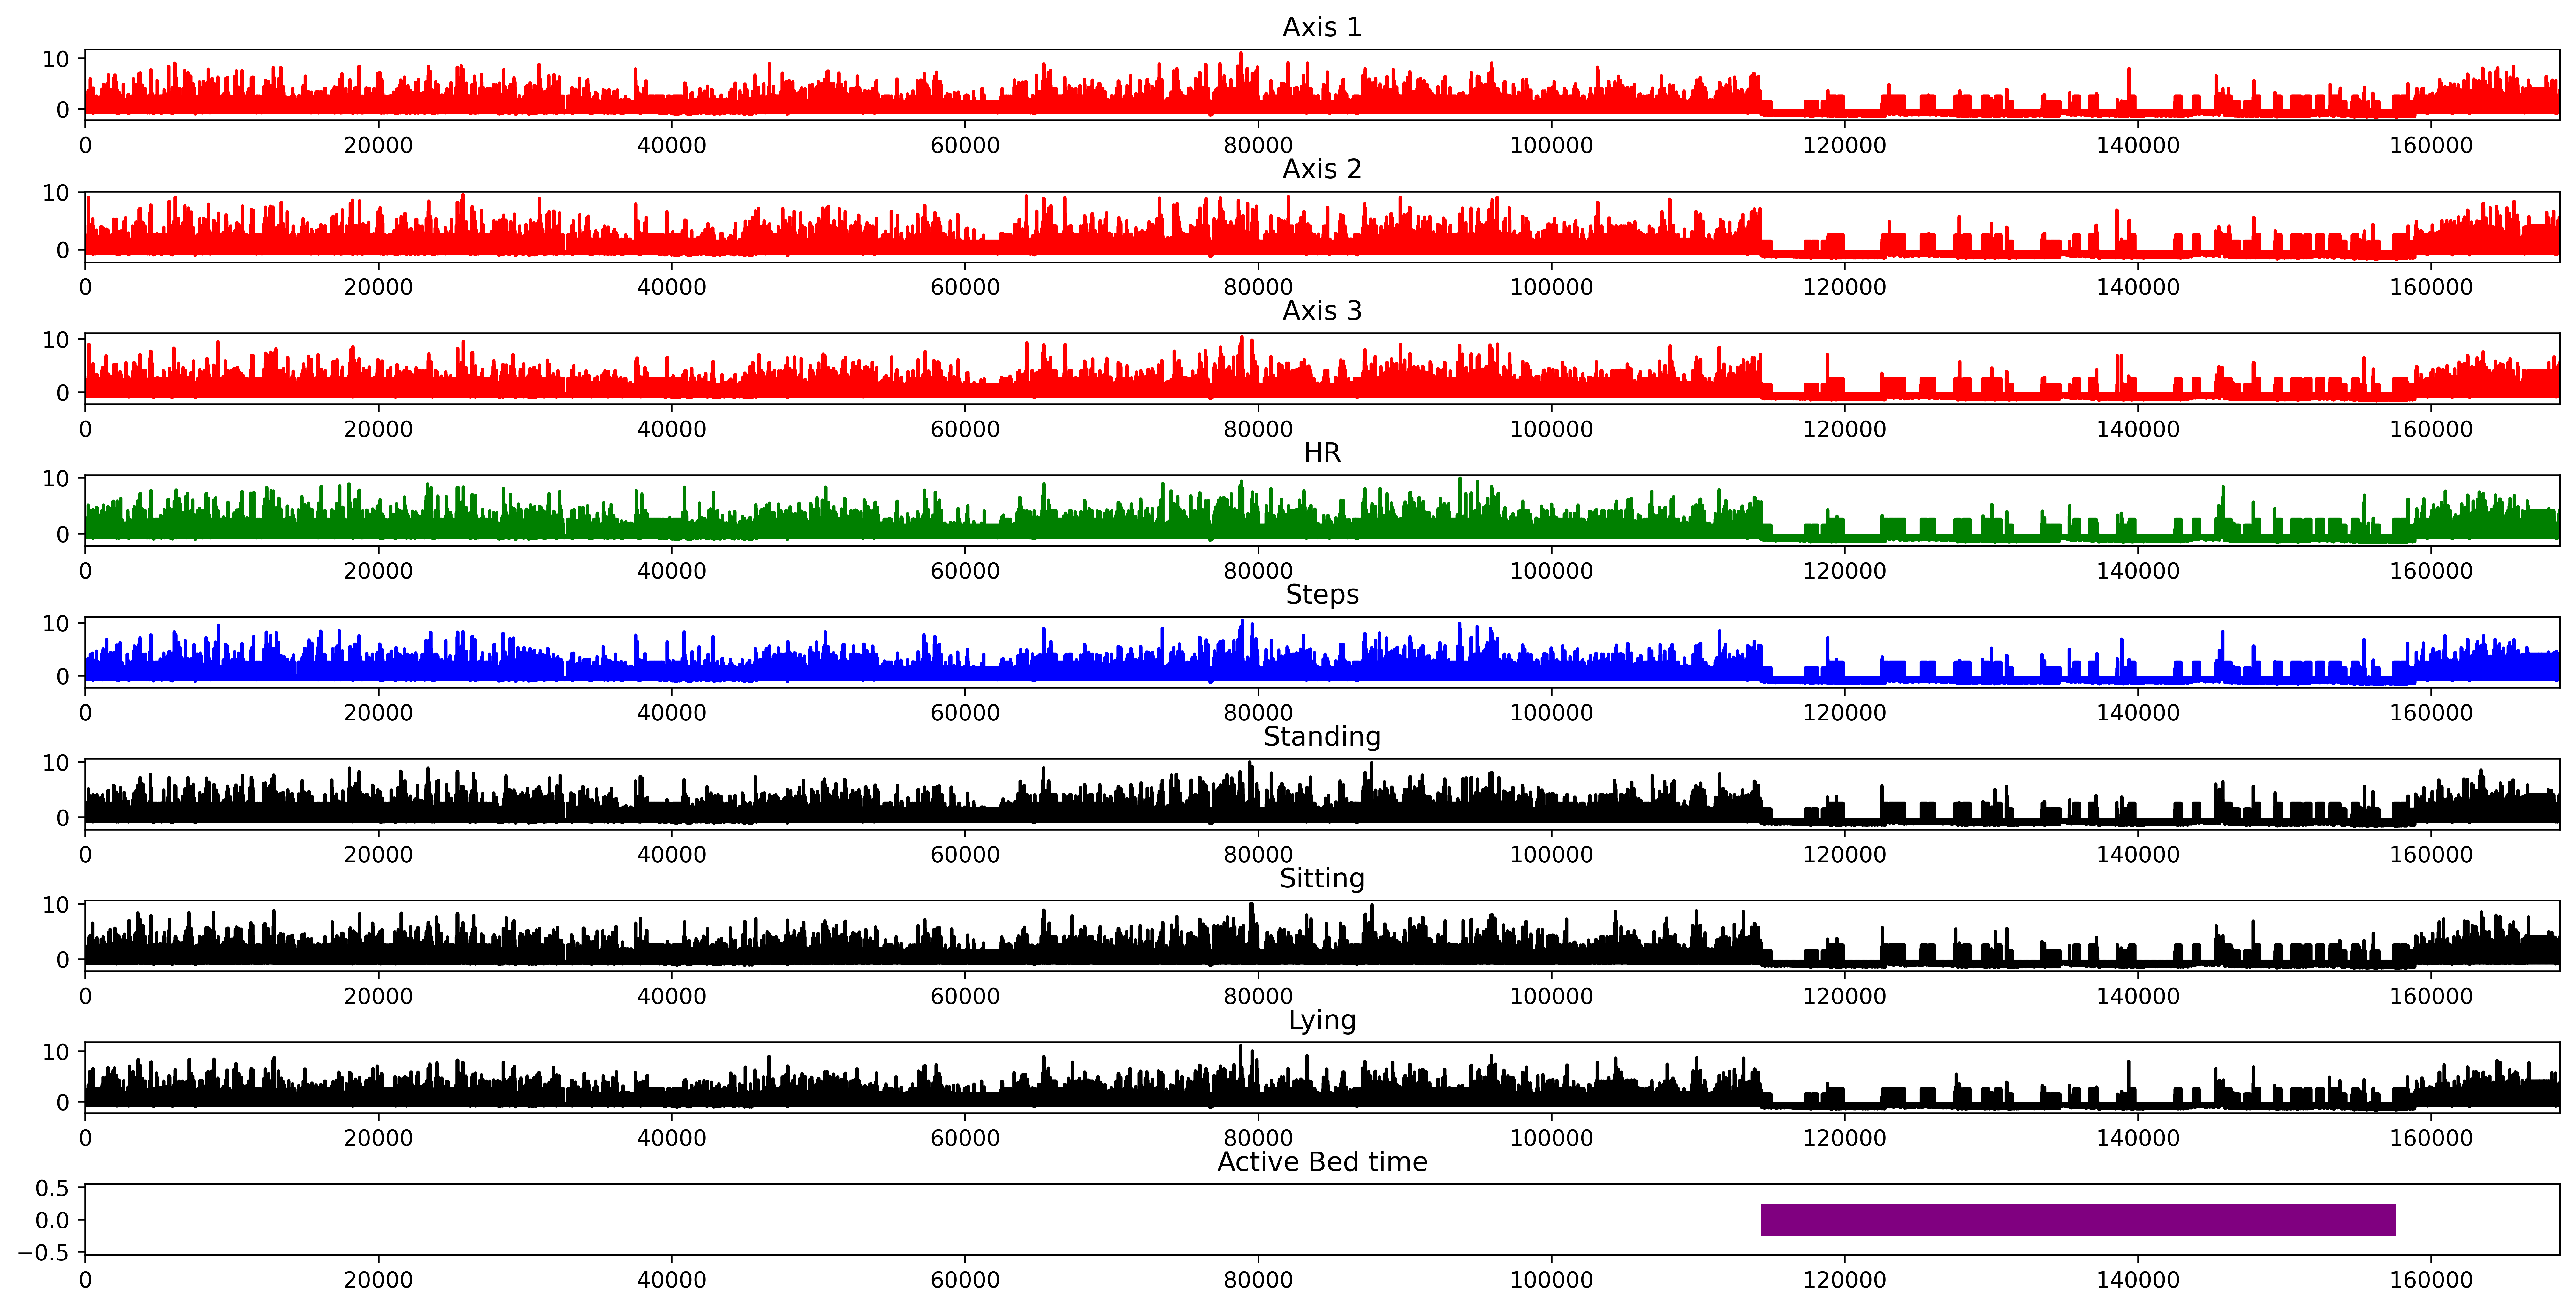

Example visualization with smoothing


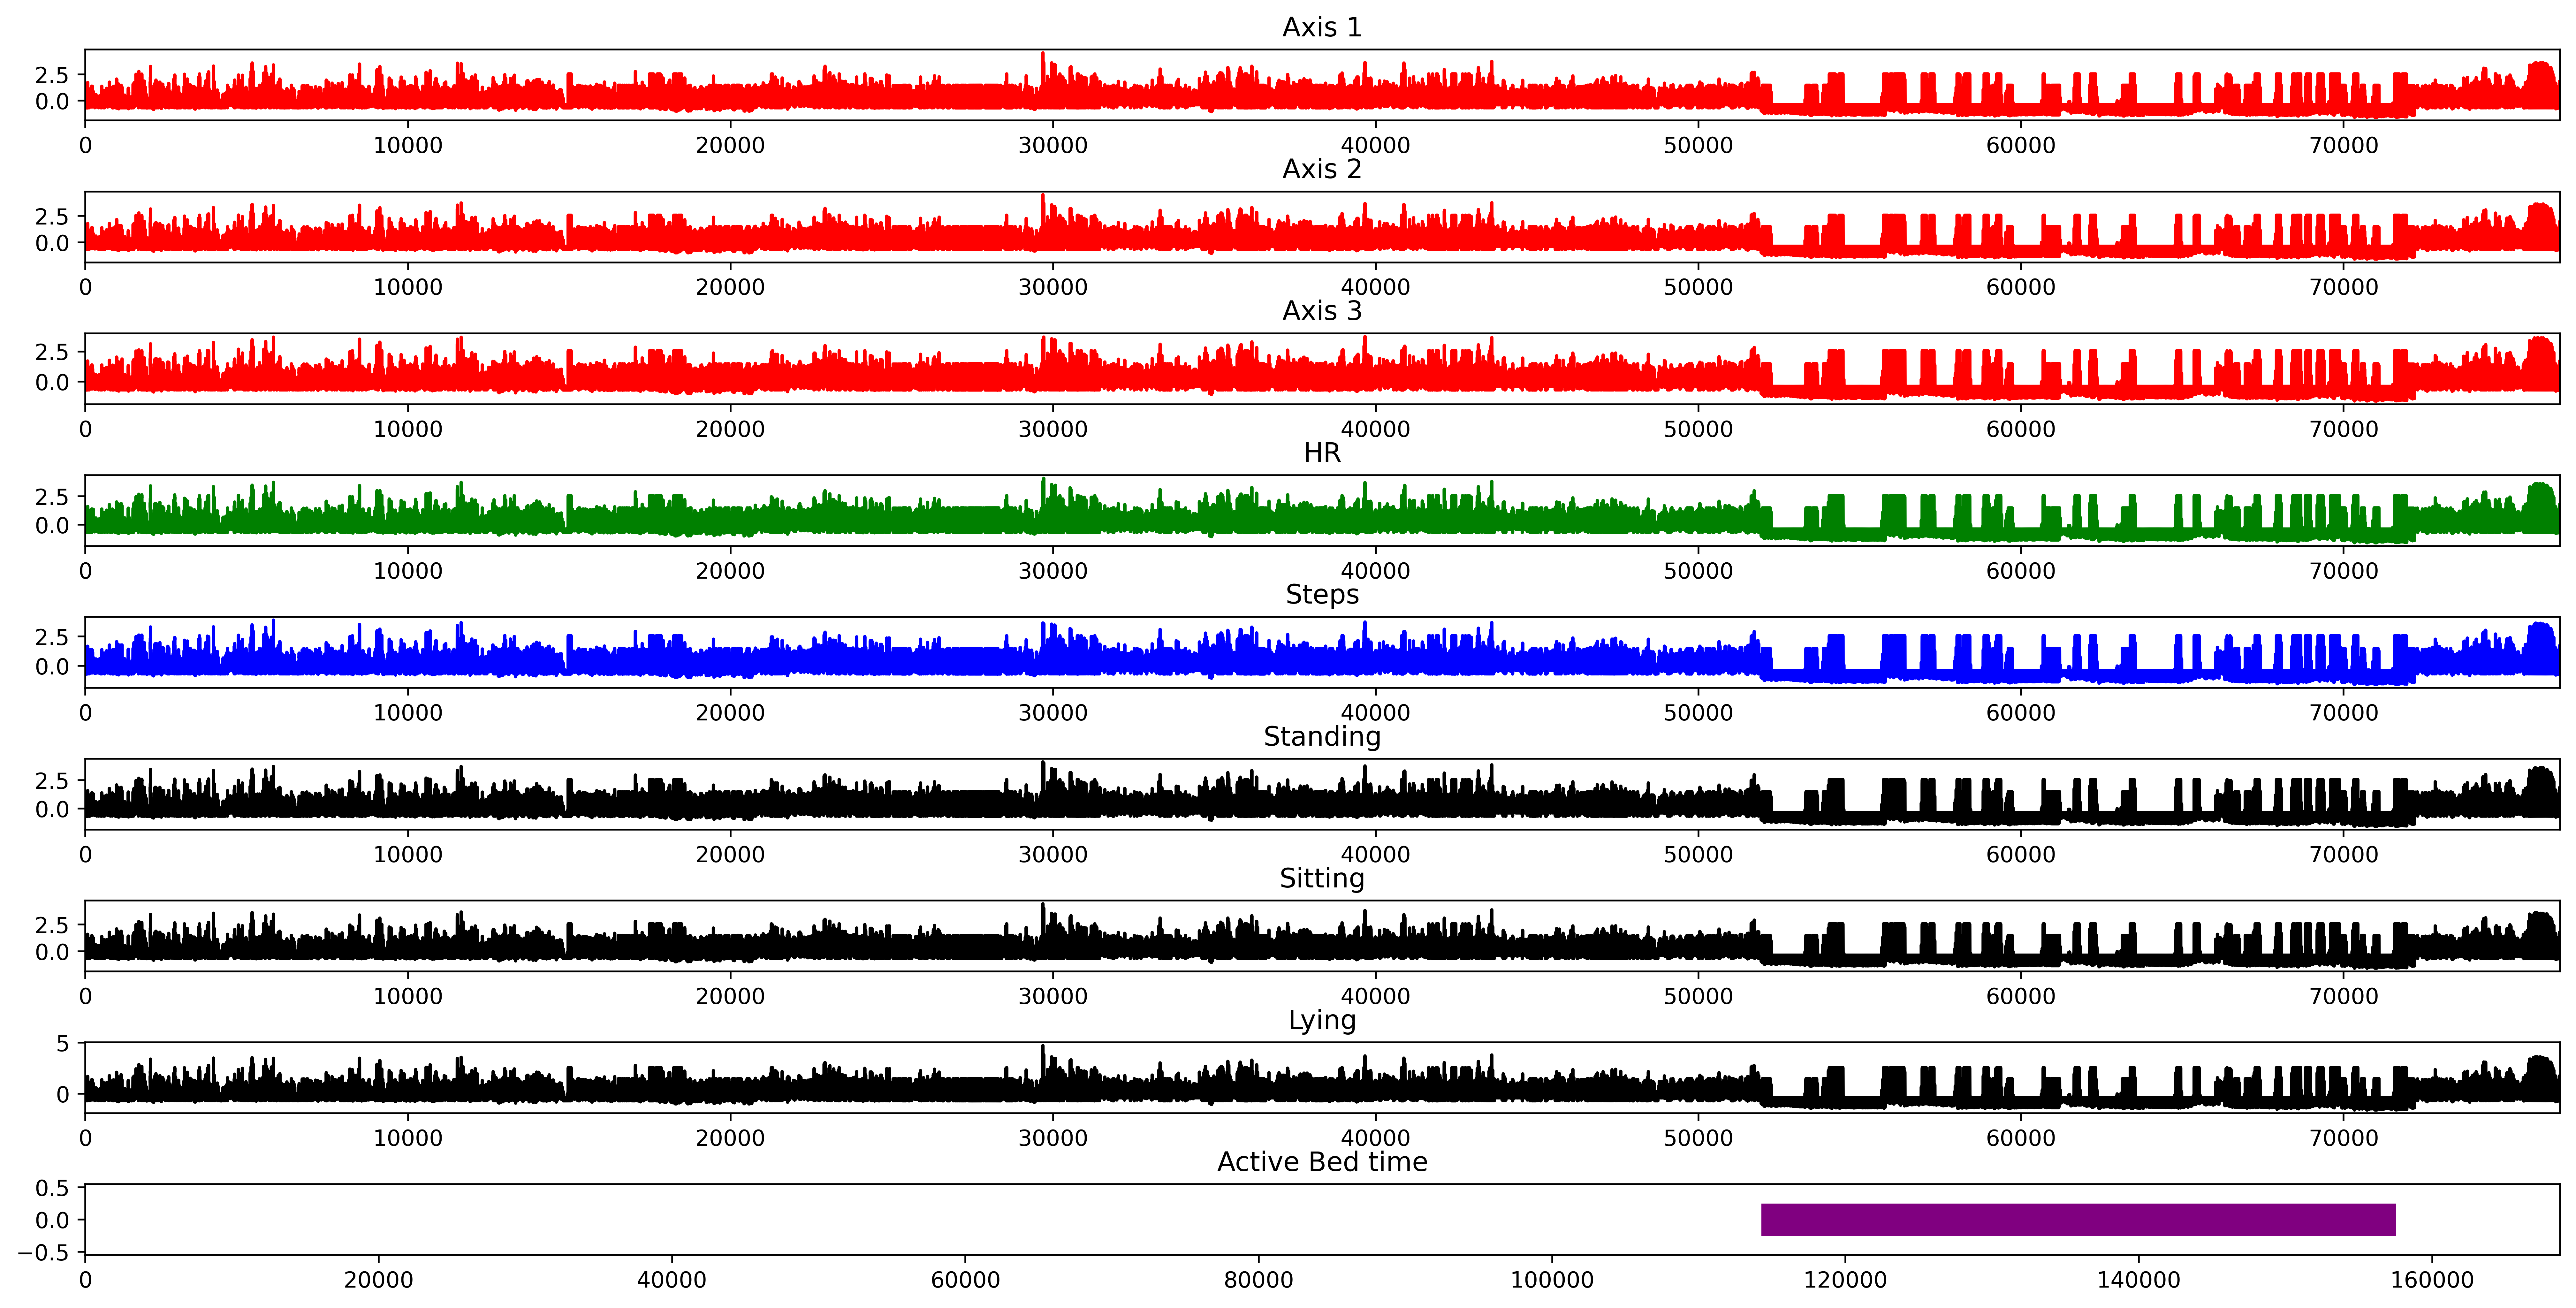

In [15]:
def example_preprocess(user, smoothing=True):

    window_size = 30
    stride_size = 15
    
    if smoothing:
        x_pipeline = Pipeline([
            ('missing_data_values', MissingDataValues()),
            ('signal_smoothing', SignalSmoothing(window_size)),
            ('standardize_data', StandardizeData(standard_scaler_scale, standard_scaler_mean, standard_scaler_var)),
            ('sliding_window', SlidingWindow(window_size = window_size, stride_size = 33)),
        ])
    else:
        x_pipeline = Pipeline([
            ('missing_data_values', MissingDataValues()),
    #         ('signal_smoothing', SignalSmoothing(window_size)),
            ('standardize_data', StandardizeData(standard_scaler_scale, standard_scaler_mean, standard_scaler_var)),
            ('sliding_window', SlidingWindow(window_size = window_size, stride_size = stride_size)),
        ])

    # x data processing
    df_x = os.path.join(data_dir, user,'Actigraph.csv')
    df_x = pd.read_csv(df_x, index_col=0, usecols=[0,1,2,3,4,5,7,8,9])
    x = x_pipeline.fit_transform(df_x)

    # y labels processing
    # Signal length and starting timestamp
    df_signal = pd.read_csv(os.path.join(data_dir, user, 'Actigraph.csv'), usecols=[0,11,12])
    signal_length = df_signal.iloc[:,0].max() - df_signal.iloc[:,0].min() + 1
    signal_start_timestamp = str(df_signal.iloc[0, 1]) + ':' \
                            + df_signal.iloc[0, 2]

    # Sleep diary (y data)
    df_y = os.path.join(data_dir, user, 'sleep.csv')
    df_y = pd.read_csv(df_y, usecols=[1,2,9])

    if smoothing:
        
        y_pipeline = Pipeline([
            ('compute_sleep_labels', ComputeSleepLabels(signal_length = signal_length, signal_start_timestamp = signal_start_timestamp)),
            ('label_smoothing', LabelSmoothing(window_size)),
            ('sliding_window', SlidingWindow(window_size=window_size, stride_size=stride_size)),
            ('label_windows', LabelWindows()),

        ])
    else:
        y_pipeline = Pipeline([
            ('compute_sleep_labels', ComputeSleepLabels(signal_length = signal_length, signal_start_timestamp = signal_start_timestamp)),
    #         ('label_smoothing', LabelSmoothing(window_size)),
            ('sliding_window', SlidingWindow(window_size=window_size, stride_size=stride_size)),
            ('label_windows', LabelWindows()),

        ])

    y = y_pipeline.fit_transform(df_y)
    
    return x, y

def example_plot(user, smoothing=True):
    
    example_x, example_y = example_preprocess(user, smoothing=smoothing)
    example_x = example_x.reshape(-1, 8)
    figure = plt.figure(figsize=(20,10), dpi=500)
    figure.subplots_adjust(hspace=1)
    ax1 = figure.add_subplot(911)
    ax1.set_xlim([0, example_x.shape[0]])
    ax1.set_title('Axis 1')
    ax1.plot(example_x[:,0], c='r')

    ax2 = figure.add_subplot(912)
    ax2.set_xlim([0, example_x.shape[0]])
    ax2.set_title('Axis 2')
    ax2.plot(example_x[:,1], c='r')

    ax3 = figure.add_subplot(913)
    ax3.set_xlim([0, example_x.shape[0]])
    ax3.set_title('Axis 3')
    ax3.plot(example_x[:,2], c='r')


    ax4 = figure.add_subplot(914)
    ax4.set_xlim([0, example_x.shape[0]])
    ax4.set_title('HR')
    ax4.plot(example_x[:,4], c='g')


    ax5 = figure.add_subplot(915)
    ax5.set_xlim([0, example_x.shape[0]])
    ax5.set_title('Steps')
    ax5.plot(example_x[:,3], c='b')


    ax6 = figure.add_subplot(916)
    ax6.set_xlim([0, example_x.shape[0]])
    ax6.set_title('Standing')
    ax6.plot(example_x[:,5], c='black')

    ax7 = figure.add_subplot(917)
    ax7.set_xlim([0, example_x.shape[0]])
    ax7.set_title('Sitting')
    ax7.plot(example_x[:,6], c='black')


    ax8 = figure.add_subplot(918)
    ax8.set_xlim([0, example_x.shape[0]])
    ax8.set_title('Lying')
    ax8.plot(example_x[:,7], c='black')

    ax9 = figure.add_subplot(919)
    ax9.set_title('Active Bed time')
    example_y = np.repeat(example_y, 30)
    ax9.set_xlim([0, example_y.shape[0]])
    example_y = np.arange(0,example_y.shape[0]) * example_y
    example_y = example_y[example_y>0]

    ax9.eventplot(example_y, lineoffsets=[0], linelengths=[0.5], colors='purple')
    plt.show()
    

print('Example visualization without smoothing')
example_plot(train_users[1], smoothing=False)
print('Example visualization with smoothing')
example_plot(train_users[1], smoothing=True)


Number of each class

Balanced class weights

In [16]:
values, counts = np.unique(train_y.flatten(), return_counts=True)
print(values, counts)
print(train_y.shape)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=values, y=train_y.flatten())
class_weights = dict(enumerate(class_weights))
print(class_weights)

[0 1] [49639 19331]
(2299, 30)
{0: 0.694715848425633, 1: 1.7839221975065955}


Build network model

In [154]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

def build_model(kernel_size=7, filters=64, dropout=0.5, learning_rate=1e-04):
    
    sequence_size=30
    model = keras.Sequential()
    
    model.add(layers.Conv2D(
        filters=filters,
        kernel_size=(kernel_size,kernel_size),
        strides=(1,1),
        padding='same',
        data_format='channels_last'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(
        pool_size=(1,5),
        strides=(1,5),
        padding='valid',
        data_format='channels_last'
    ))
    model.add(layers.Dropout(dropout))
    
    
    model.add(layers.Conv2D(
        filters=filters,
        kernel_size=(kernel_size,kernel_size),
        strides=(1,1),
        padding='same',
        data_format='channels_last'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(
        pool_size=(1,3),
        strides=(1,3),
        padding='valid',
        data_format='channels_last'
    ))
    model.add(layers.Dropout(dropout))
    
    
    model.add(layers.Conv2D(
        filters=filters,
        kernel_size=(kernel_size,kernel_size),
        strides=(1,1),
        padding='same',
        data_format='channels_last'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(
        pool_size=(1,2),
        strides=(1,2),
        padding='valid',
        data_format='channels_last'
    ))
    model.add(layers.Dropout(dropout))
    
    
    model.add(layers.Reshape((sequence_size,filters)))
    
    
    model.add(layers.Bidirectional(
            layer = layers.GRU(units=filters, return_sequences=False,),
            backward_layer = layers.GRU(units=filters, return_sequences=False, go_backwards=True,),
            merge_mode='concat',
    ))

    model.add(layers.Dense(filters))
    model.add(layers.Dense(sequence_size, activation='sigmoid',
                              kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)
    ))
    
    
    model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
#               metrics=[auc],
    )
    
    return model

# auc = tf.keras.metrics.AUC()

Train model

In [98]:
train_x.shape, train_y.shape
# val_x.shape, val_y.shape

((2299, 30, 30, 8), (2299, 30))

Epoch 1/50
72/72 [==============================] - 4s 18ms/step - loss: 0.5373 - val_loss: 0.5324
Epoch 2/50
72/72 [==============================] - 1s 11ms/step - loss: 0.2972 - val_loss: 0.3802
Epoch 3/50
72/72 [==============================] - 1s 11ms/step - loss: 0.2336 - val_loss: 0.3476
Epoch 4/50
72/72 [==============================] - 1s 11ms/step - loss: 0.2015 - val_loss: 0.3075
Epoch 5/50
72/72 [==============================] - 1s 11ms/step - loss: 0.1935 - val_loss: 0.2992
Epoch 6/50
72/72 [==============================] - 1s 11ms/step - loss: 0.1860 - val_loss: 0.2993
Epoch 7/50
72/72 [==============================] - 1s 11ms/step - loss: 0.1831 - val_loss: 0.2834
Epoch 8/50
72/72 [==============================] - 1s 12ms/step - loss: 0.1719 - val_loss: 0.3015
Epoch 9/50
72/72 [==============================] - 1s 11ms/step - loss: 0.1769 - val_loss: 0.2651
Epoch 10/50
72/72 [==============================] - 1s 11ms/step - loss: 0.1768 - val_loss: 0.3002
Epoch 11/

Text(0.5, 1.0, 'Training vs validation loss')

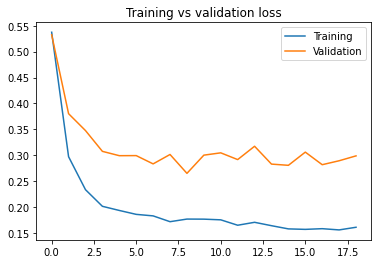

In [155]:

model = build_model()
history = model.fit(x=train_x,y=train_y,validation_data=(val_x, val_y),epochs=50, batch_size=32,
#                     class_weight=class_weights,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, 
                                                          monitor='val_loss',
                                                          mode='min', 
                                                          restore_best_weights=True
                                                         )], )

model.summary()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training vs validation loss')

In [47]:
model_dir = os.path.join('C:/Users/Thomas/OneDrive/Desktop/cerno_project', 'model')
print(model_dir)
model.save(model_dir)
model.save_weights(model_dir + '/weights/model_weights')


C:/Users/Thomas/OneDrive/Desktop/cerno_project\model


INFO:tensorflow:Assets written to: C:/Users/Thomas/OneDrive/Desktop/cerno_project\model\assets


INFO:tensorflow:Assets written to: C:/Users/Thomas/OneDrive/Desktop/cerno_project\model\assets


In [156]:
model.evaluate(test_x, test_y)

15/15 [==============================] - 0s 5ms/step - loss: 0.1798


0.17984053492546082

In [115]:
test_x.shape, test_y.shape

((719, 20, 30, 8), (719, 20))

['user_13', 'user_6', 'user_15', 'user_1', 'user_7']
(14370,)
<class 'numpy.int32'>
Best Threshold: 0.15780000388622284 with G-Mean: 0.9444
FPR: 0.0964, TPR: 0.9871


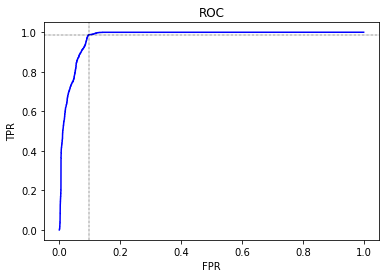

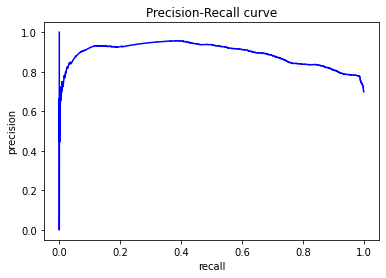

array([[9701, 1035],
       [  48, 3586]], dtype=int64)

Accuracy: 0.925
Precision: 0.776
Recall: 0.987
F1: 0.869


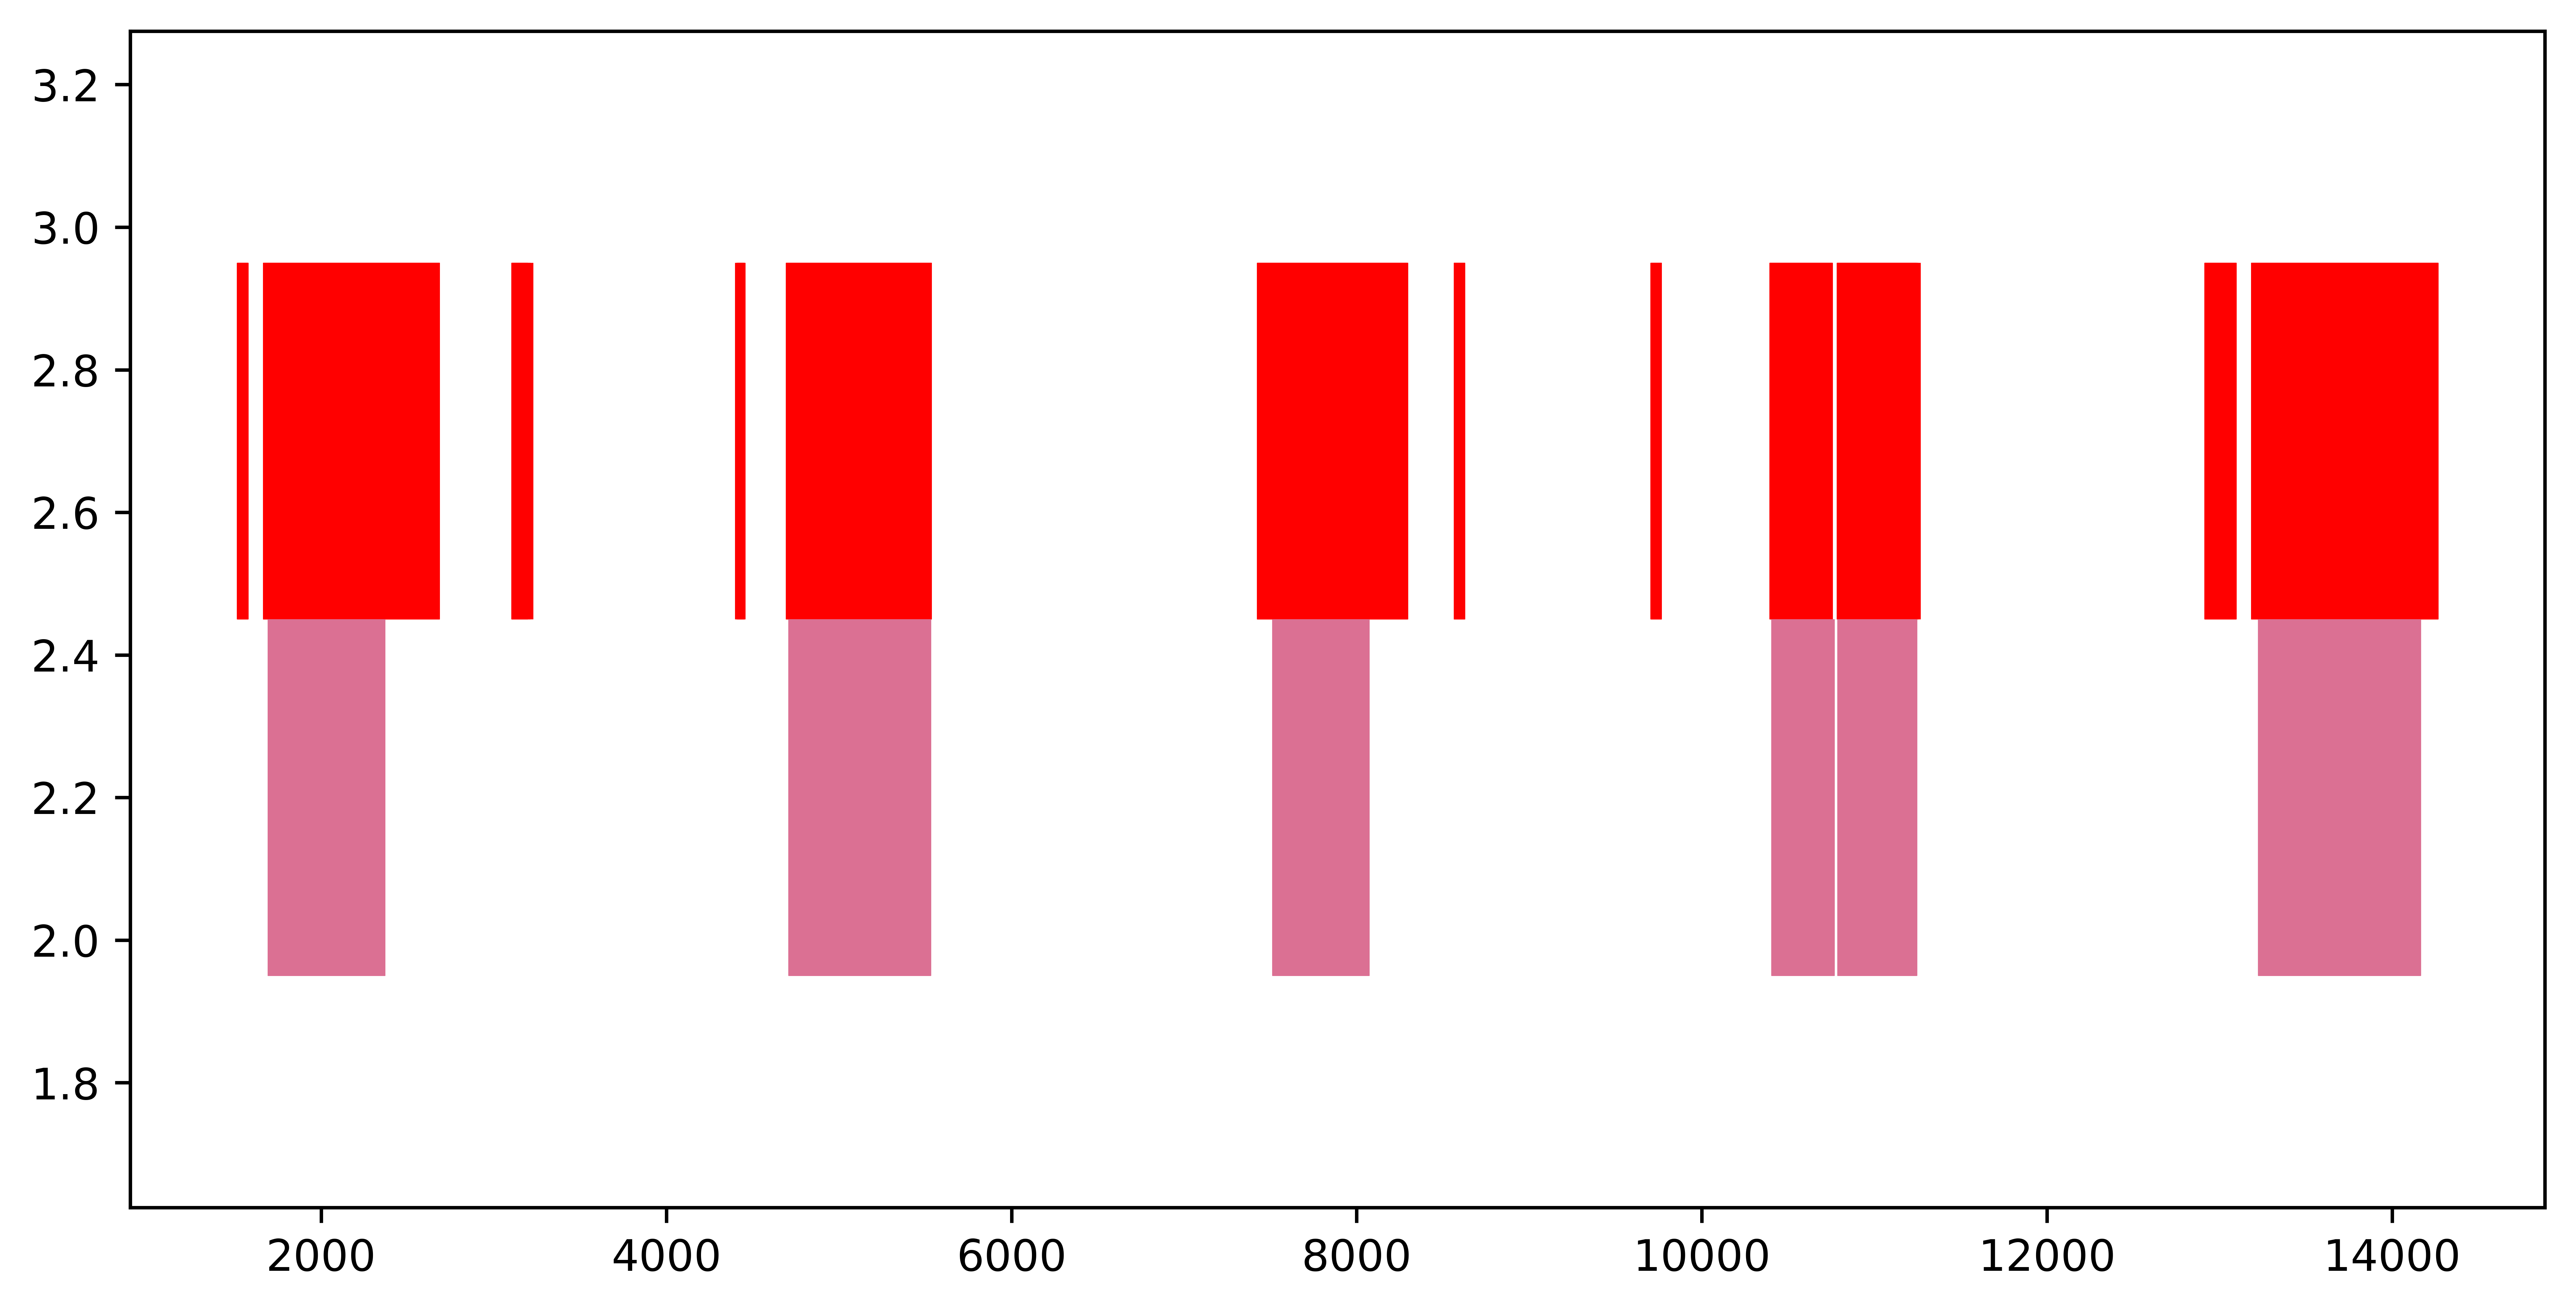

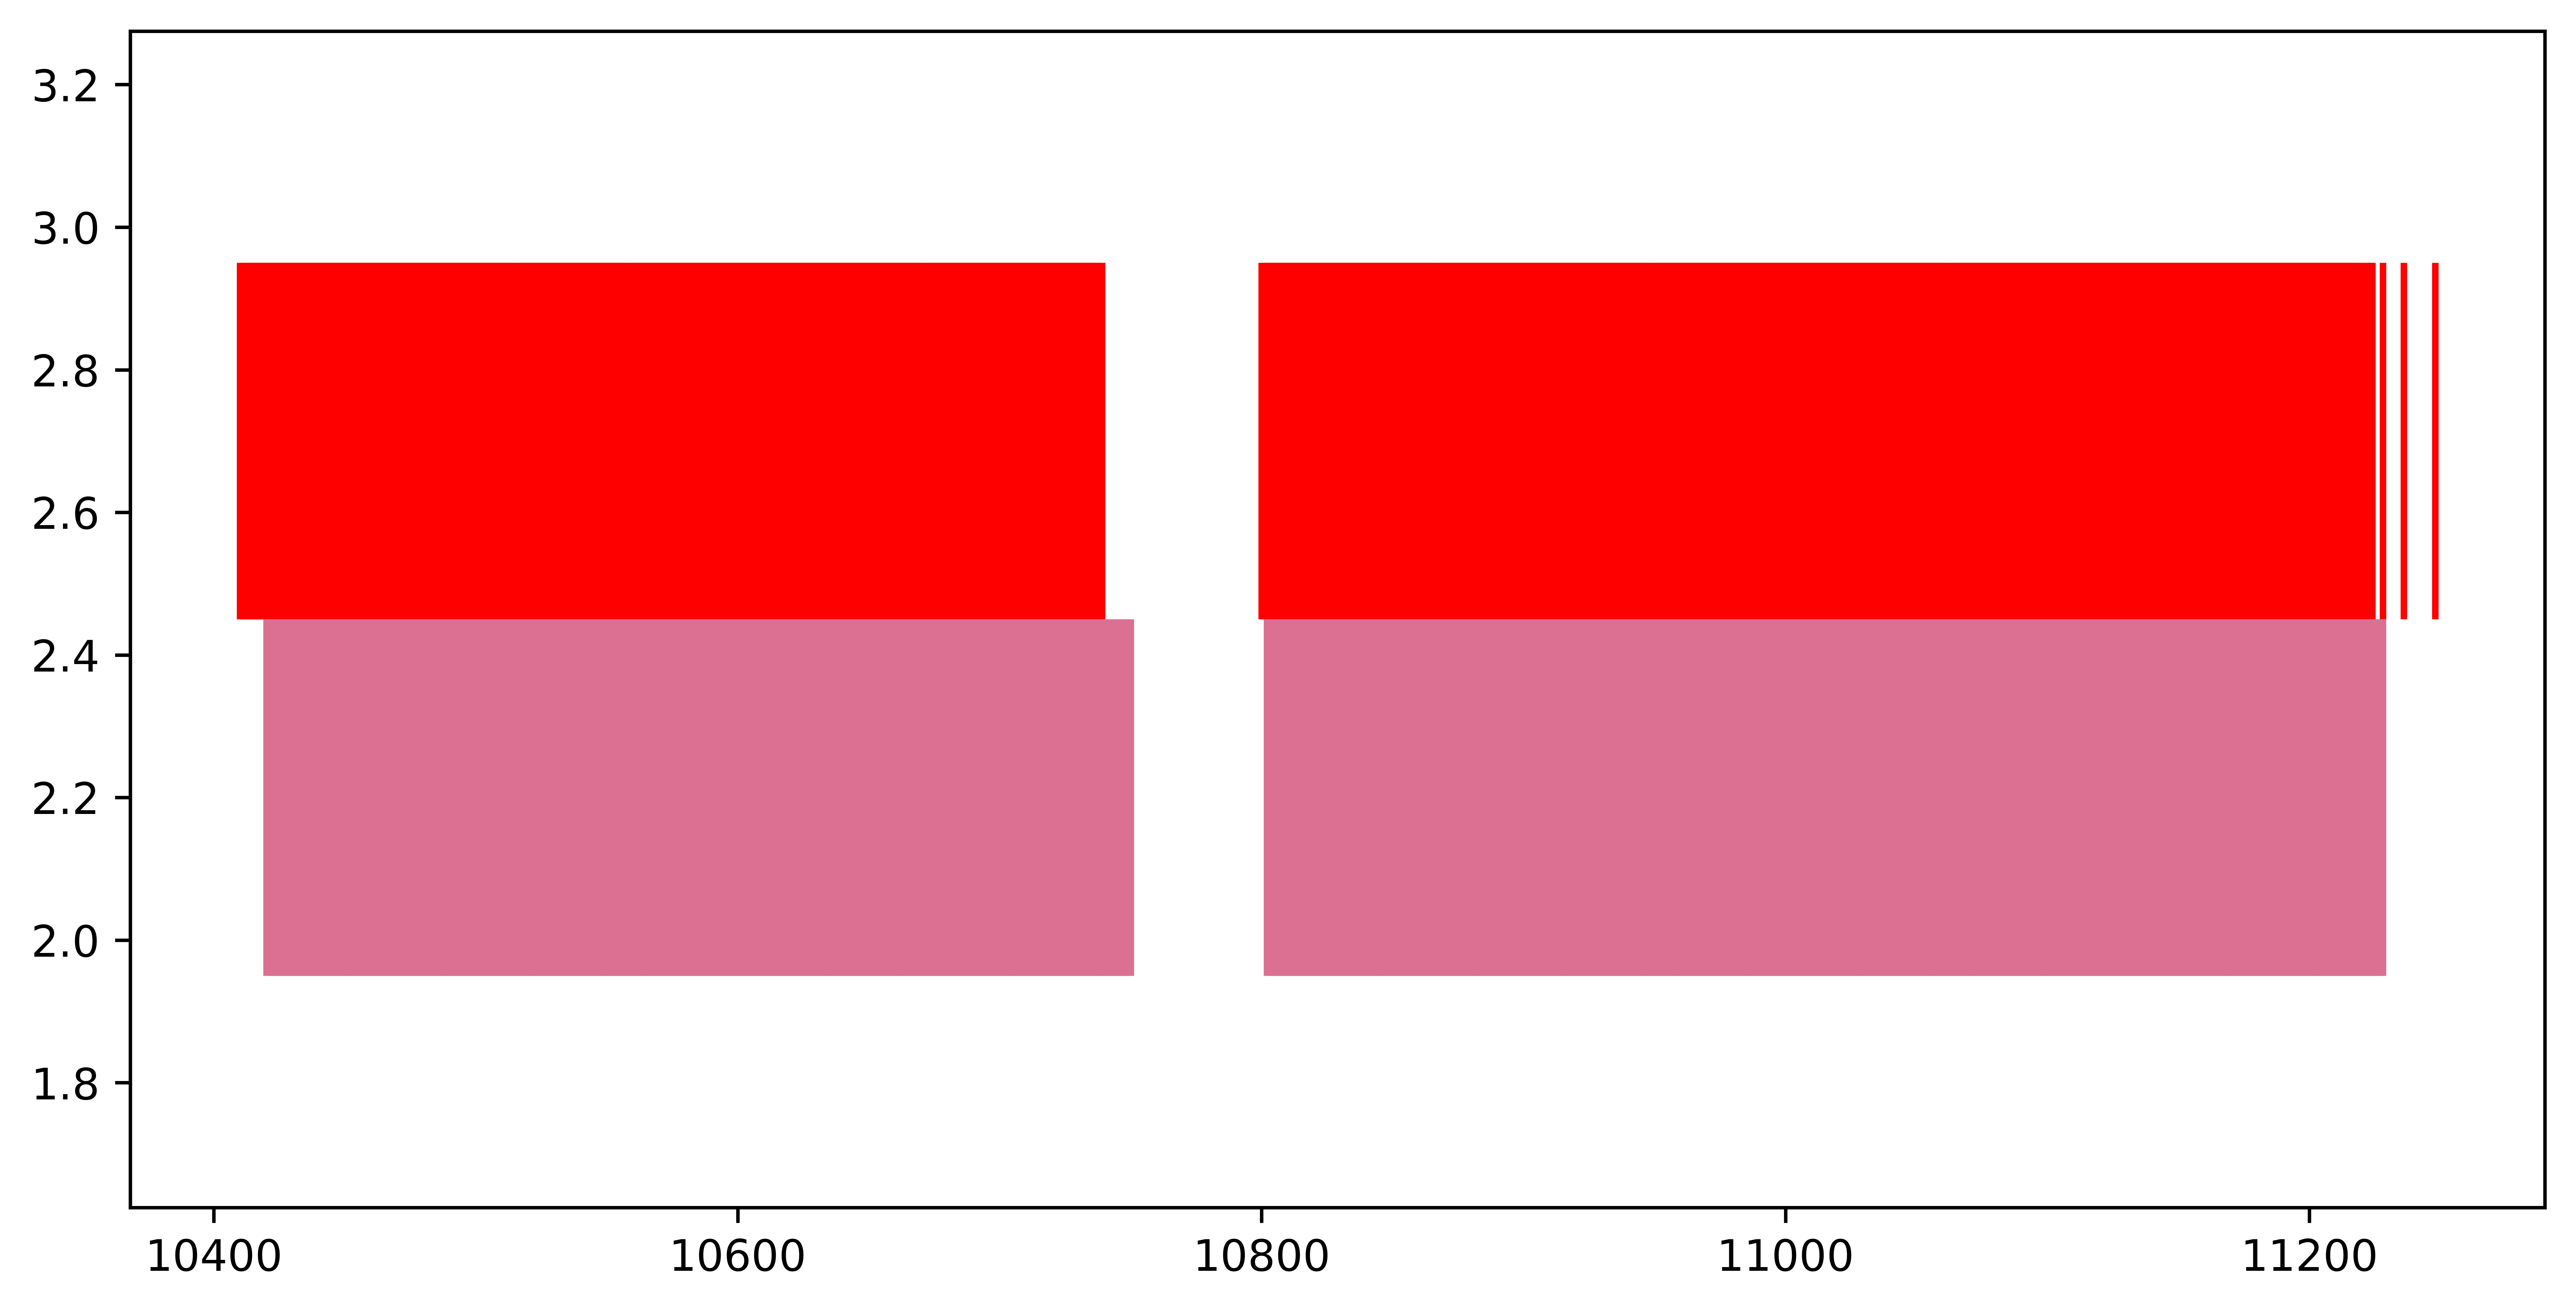

In [157]:
print(test_users)

pred = model.predict(test_x)
pred = pred.flatten()
true = test_y.flatten()
print(pred.shape)
print(type(true[0]))

from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(true, pred)

# geometric mean(G-mean) of sensitivity and specificity.
gmean = np.sqrt(tpr * (1 - fpr))
# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(threshold[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))



plt.plot(fpr, tpr, 'b')
plt.axhline(y=tpr[index], color='black', linestyle='-.', linewidth=0.4)
plt.axvline(x=fpr[index], color='black', linestyle='-.', linewidth=0.4)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(true, pred)
plt.plot(recall, precision, 'b')
plt.title('Precision-Recall curve')
plt.xlabel('recall')
plt.ylabel('precision')

plt.show()


pred = (pred > thresholdOpt).astype(float)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true, pred)
display(cm)
accuracy = (cm[1,1] + cm[0,0]) / (cm[1,1] + cm[0,0] + cm[0,1] + cm[1,0])
precision = (cm[1,1]) / (cm[1,1] + cm[0,1] + 1e-16)
recall = (cm[1,1]) / (cm[1,1] + cm[1,0] + 1e-16)
f1 = (2 * precision * recall) / (precision + recall + 1e-16)

print('Accuracy:', round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1:', round(f1, 3))

pred = np.arange(0,pred.shape[0]) * pred
pred = pred[pred>0]
true = np.arange(0,true.shape[0]) * true
true = true[true>0]


fig = plt.figure(figsize=(10,5), dpi=1000)
ax = fig.add_subplot(111)
ax.eventplot(pred, lineoffsets=[2.7], linelengths=[0.5], colors='r')
ax.eventplot(true, lineoffsets=[2.2], linelengths=[0.5], colors='palevioletred')
plt.show()

fig2 = plt.figure(figsize=(10,5), dpi=1000)
ax2 = fig2.add_subplot(111)
ax2.eventplot(pred[(pred>10000)&(pred<12000)], lineoffsets=[2.7], linelengths=[0.5], colors='r')
ax2.eventplot(true[(true>10000)&(true<12000)], lineoffsets=[2.2], linelengths=[0.5], colors='palevioletred')
plt.show()



In [ ]:
# import pickle

model = build_model()
history = model.fit(x=train_x,y=train_y,validation_data=(val_x, val_y),epochs=50, batch_size=32, class_weight=class_weights,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, 
                                                          monitor='val_loss',
                                                          mode='min', 
                                                          restore_best_weights=True
                                                         )], )

model.summary()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training vs validation loss')

randomized search cross validation for hyperparameter tuning

In [123]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# verbose=1
import pickle

model = KerasRegressor(build_fn = build_model, verbose=0)

param_distribs = {
    'kernel_size': [3,5,7,9,11],
    'filters': [64,128,256],
    'learning_rate': [1e-02,1e-03,1e-04],
    'dropout': [0.125,.25, 0.375, 0.5],
    'batch_size': [16,32,64,128]
}


from sklearn.metrics import f1_score, make_scorer
def f1_score_metric(y_true, y_pred):
    y_pred = (y_pred.flatten() > 0.5).astype(int)
    y_true = y_true.flatten()
    return f1_score(y_true, y_pred)
f1 = make_scorer(f1_score_metric, greater_is_better=True)

rs = RandomizedSearchCV(estimator=model,
                param_distributions=param_distribs,
                cv=3,
                n_iter=300,
                scoring=f1,
                refit=f1,
                verbose=4)

rs.fit(train_x, 
       train_y,
       epochs=50,
       validation_data=(val_x, val_y),
       callbacks=[keras.callbacks.EarlyStopping(patience=10, 
                                                monitor='val_loss',
                                                mode='min', 
                                                restore_best_weights=True,
                                               )])



Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV 1/3] END batch_size=64, dropout=0.375, filters=128, kernel_size=9, learning_rate=0.001;, score=0.832 total time=  15.7s
[CV 2/3] END batch_size=64, dropout=0.375, filters=128, kernel_size=9, learning_rate=0.001;, score=0.926 total time=  24.7s
[CV 3/3] END batch_size=64, dropout=0.375, filters=128, kernel_size=9, learning_rate=0.001;, score=0.823 total time=  14.6s
[CV 1/3] END batch_size=32, dropout=0.125, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.898 total time=  17.1s
[CV 2/3] END batch_size=32, dropout=0.125, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.912 total time=  13.2s
[CV 3/3] END batch_size=32, dropout=0.125, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.823 total time=  12.2s
[CV 1/3] END batch_size=32, dropout=0.375, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.891 total time=  12.8s
[CV 2/3] END batch_size=32, dropout=0.375, filters=64, kernel_size=7,

[CV 1/3] END batch_size=32, dropout=0.375, filters=256, kernel_size=5, learning_rate=0.001;, score=0.906 total time=  26.9s
[CV 2/3] END batch_size=32, dropout=0.375, filters=256, kernel_size=5, learning_rate=0.001;, score=0.909 total time=  16.3s
[CV 3/3] END batch_size=32, dropout=0.375, filters=256, kernel_size=5, learning_rate=0.001;, score=0.834 total time=  25.2s
[CV 1/3] END batch_size=64, dropout=0.5, filters=128, kernel_size=5, learning_rate=0.0001;, score=0.904 total time=  10.8s
[CV 2/3] END batch_size=64, dropout=0.5, filters=128, kernel_size=5, learning_rate=0.0001;, score=0.934 total time=   9.7s
[CV 3/3] END batch_size=64, dropout=0.5, filters=128, kernel_size=5, learning_rate=0.0001;, score=0.828 total time=   9.5s
[CV 1/3] END batch_size=128, dropout=0.375, filters=64, kernel_size=3, learning_rate=0.001;, score=0.901 total time=   9.3s
[CV 2/3] END batch_size=128, dropout=0.375, filters=64, kernel_size=3, learning_rate=0.001;, score=0.930 total time=   8.2s
[CV 3/3] EN

[CV 2/3] END batch_size=32, dropout=0.25, filters=256, kernel_size=3, learning_rate=0.0001;, score=0.917 total time=  20.0s
[CV 3/3] END batch_size=32, dropout=0.25, filters=256, kernel_size=3, learning_rate=0.0001;, score=0.744 total time=  12.4s
[CV 1/3] END batch_size=16, dropout=0.25, filters=64, kernel_size=11, learning_rate=0.01;, score=0.894 total time=  29.9s
[CV 2/3] END batch_size=16, dropout=0.25, filters=64, kernel_size=11, learning_rate=0.01;, score=0.939 total time=  29.0s
[CV 3/3] END batch_size=16, dropout=0.25, filters=64, kernel_size=11, learning_rate=0.01;, score=0.820 total time=  25.5s
[CV 1/3] END batch_size=64, dropout=0.125, filters=256, kernel_size=11, learning_rate=0.0001;, score=0.897 total time=  19.4s
[CV 2/3] END batch_size=64, dropout=0.125, filters=256, kernel_size=11, learning_rate=0.0001;, score=0.930 total time=  22.4s
[CV 3/3] END batch_size=64, dropout=0.125, filters=256, kernel_size=11, learning_rate=0.0001;, score=0.821 total time=  20.6s
[CV 1/3]

[CV 3/3] END batch_size=128, dropout=0.375, filters=128, kernel_size=3, learning_rate=0.0001;, score=0.825 total time=   8.7s
[CV 1/3] END batch_size=64, dropout=0.25, filters=64, kernel_size=3, learning_rate=0.0001;, score=0.879 total time=   9.8s
[CV 2/3] END batch_size=64, dropout=0.25, filters=64, kernel_size=3, learning_rate=0.0001;, score=0.930 total time=  16.0s
[CV 3/3] END batch_size=64, dropout=0.25, filters=64, kernel_size=3, learning_rate=0.0001;, score=0.824 total time=   9.4s
[CV 1/3] END batch_size=32, dropout=0.25, filters=256, kernel_size=7, learning_rate=0.0001;, score=0.893 total time=  24.5s
[CV 2/3] END batch_size=32, dropout=0.25, filters=256, kernel_size=7, learning_rate=0.0001;, score=0.930 total time=  25.7s
[CV 3/3] END batch_size=32, dropout=0.25, filters=256, kernel_size=7, learning_rate=0.0001;, score=0.819 total time=  17.5s
[CV 1/3] END batch_size=32, dropout=0.5, filters=128, kernel_size=5, learning_rate=0.001;, score=0.900 total time=  20.8s
[CV 2/3] EN

[CV 1/3] END batch_size=64, dropout=0.5, filters=128, kernel_size=11, learning_rate=0.0001;, score=0.865 total time=  12.1s
[CV 2/3] END batch_size=64, dropout=0.5, filters=128, kernel_size=11, learning_rate=0.0001;, score=0.933 total time=  13.9s
[CV 3/3] END batch_size=64, dropout=0.5, filters=128, kernel_size=11, learning_rate=0.0001;, score=0.829 total time=  17.0s
[CV 1/3] END batch_size=32, dropout=0.25, filters=128, kernel_size=7, learning_rate=0.001;, score=0.874 total time=  16.6s
[CV 2/3] END batch_size=32, dropout=0.25, filters=128, kernel_size=7, learning_rate=0.001;, score=0.903 total time=  26.8s
[CV 3/3] END batch_size=32, dropout=0.25, filters=128, kernel_size=7, learning_rate=0.001;, score=0.821 total time=  22.0s
[CV 1/3] END batch_size=128, dropout=0.375, filters=256, kernel_size=7, learning_rate=0.0001;, score=0.892 total time=  13.5s
[CV 2/3] END batch_size=128, dropout=0.375, filters=256, kernel_size=7, learning_rate=0.0001;, score=0.940 total time=  13.0s
[CV 3/3

[CV 2/3] END batch_size=32, dropout=0.5, filters=64, kernel_size=5, learning_rate=0.01;, score=0.937 total time=  20.2s
[CV 3/3] END batch_size=32, dropout=0.5, filters=64, kernel_size=5, learning_rate=0.01;, score=0.840 total time=  22.4s
[CV 1/3] END batch_size=32, dropout=0.25, filters=64, kernel_size=7, learning_rate=0.001;, score=0.900 total time=  22.1s
[CV 2/3] END batch_size=32, dropout=0.25, filters=64, kernel_size=7, learning_rate=0.001;, score=0.914 total time=  20.7s
[CV 3/3] END batch_size=32, dropout=0.25, filters=64, kernel_size=7, learning_rate=0.001;, score=0.835 total time=  16.0s
[CV 1/3] END batch_size=16, dropout=0.25, filters=128, kernel_size=5, learning_rate=0.001;, score=0.884 total time=  33.6s
[CV 2/3] END batch_size=16, dropout=0.25, filters=128, kernel_size=5, learning_rate=0.001;, score=0.936 total time=  43.3s
[CV 3/3] END batch_size=16, dropout=0.25, filters=128, kernel_size=5, learning_rate=0.001;, score=0.819 total time=  35.0s
[CV 1/3] END batch_size=6

[CV 3/3] END batch_size=64, dropout=0.125, filters=128, kernel_size=9, learning_rate=0.01;, score=0.839 total time=  18.5s
[CV 1/3] END batch_size=32, dropout=0.25, filters=128, kernel_size=7, learning_rate=0.0001;, score=0.894 total time=  12.4s
[CV 2/3] END batch_size=32, dropout=0.25, filters=128, kernel_size=7, learning_rate=0.0001;, score=0.933 total time=  16.9s
[CV 3/3] END batch_size=32, dropout=0.25, filters=128, kernel_size=7, learning_rate=0.0001;, score=0.824 total time=  13.0s
[CV 1/3] END batch_size=128, dropout=0.125, filters=128, kernel_size=11, learning_rate=0.01;, score=0.865 total time=  19.2s
[CV 2/3] END batch_size=128, dropout=0.125, filters=128, kernel_size=11, learning_rate=0.01;, score=0.911 total time=  15.6s
[CV 3/3] END batch_size=128, dropout=0.125, filters=128, kernel_size=11, learning_rate=0.01;, score=0.831 total time=  20.8s
[CV 1/3] END batch_size=128, dropout=0.375, filters=128, kernel_size=11, learning_rate=0.0001;, score=0.894 total time=  12.3s
[CV

[CV 1/3] END batch_size=64, dropout=0.125, filters=128, kernel_size=11, learning_rate=0.0001;, score=0.894 total time=  12.9s
[CV 2/3] END batch_size=64, dropout=0.125, filters=128, kernel_size=11, learning_rate=0.0001;, score=0.943 total time=  12.2s
[CV 3/3] END batch_size=64, dropout=0.125, filters=128, kernel_size=11, learning_rate=0.0001;, score=0.834 total time=  11.8s
[CV 1/3] END batch_size=16, dropout=0.5, filters=64, kernel_size=5, learning_rate=0.001;, score=0.871 total time=  21.4s
[CV 2/3] END batch_size=16, dropout=0.5, filters=64, kernel_size=5, learning_rate=0.001;, score=0.929 total time=  34.9s
[CV 3/3] END batch_size=16, dropout=0.5, filters=64, kernel_size=5, learning_rate=0.001;, score=0.827 total time=  35.9s
[CV 1/3] END batch_size=128, dropout=0.375, filters=64, kernel_size=7, learning_rate=0.001;, score=0.884 total time=  13.2s
[CV 2/3] END batch_size=128, dropout=0.375, filters=64, kernel_size=7, learning_rate=0.001;, score=0.922 total time=  13.1s
[CV 3/3] EN

[CV 2/3] END batch_size=32, dropout=0.375, filters=64, kernel_size=5, learning_rate=0.01;, score=0.941 total time=  20.0s
[CV 3/3] END batch_size=32, dropout=0.375, filters=64, kernel_size=5, learning_rate=0.01;, score=0.823 total time=  29.7s
[CV 1/3] END batch_size=128, dropout=0.125, filters=64, kernel_size=11, learning_rate=0.001;, score=0.648 total time=   6.5s
[CV 2/3] END batch_size=128, dropout=0.125, filters=64, kernel_size=11, learning_rate=0.001;, score=0.921 total time=  13.8s
[CV 3/3] END batch_size=128, dropout=0.125, filters=64, kernel_size=11, learning_rate=0.001;, score=0.807 total time=  11.0s
[CV 1/3] END batch_size=16, dropout=0.125, filters=128, kernel_size=7, learning_rate=0.001;, score=0.884 total time=  22.0s
[CV 2/3] END batch_size=16, dropout=0.125, filters=128, kernel_size=7, learning_rate=0.001;, score=0.933 total time=  42.5s
[CV 3/3] END batch_size=16, dropout=0.125, filters=128, kernel_size=7, learning_rate=0.001;, score=0.835 total time=  30.3s
[CV 1/3] 

[CV 3/3] END batch_size=16, dropout=0.25, filters=64, kernel_size=5, learning_rate=0.001;, score=0.824 total time=  32.4s
[CV 1/3] END batch_size=32, dropout=0.5, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.899 total time=  13.4s
[CV 2/3] END batch_size=32, dropout=0.5, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.929 total time=  13.3s
[CV 3/3] END batch_size=32, dropout=0.5, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.830 total time=  13.1s
[CV 1/3] END batch_size=16, dropout=0.5, filters=128, kernel_size=9, learning_rate=0.001;, score=0.897 total time=  35.3s
[CV 2/3] END batch_size=16, dropout=0.5, filters=128, kernel_size=9, learning_rate=0.001;, score=0.926 total time=  29.9s
[CV 3/3] END batch_size=16, dropout=0.5, filters=128, kernel_size=9, learning_rate=0.001;, score=0.813 total time=  40.0s
[CV 1/3] END batch_size=128, dropout=0.125, filters=128, kernel_size=9, learning_rate=0.001;, score=0.701 total time=   7.4s
[CV 2/3] END batch_si

[CV 1/3] END batch_size=16, dropout=0.25, filters=64, kernel_size=3, learning_rate=0.001;, score=0.894 total time=  35.4s
[CV 2/3] END batch_size=16, dropout=0.25, filters=64, kernel_size=3, learning_rate=0.001;, score=0.925 total time=  28.2s
[CV 3/3] END batch_size=16, dropout=0.25, filters=64, kernel_size=3, learning_rate=0.001;, score=0.824 total time=  20.0s
[CV 1/3] END batch_size=128, dropout=0.125, filters=128, kernel_size=3, learning_rate=0.01;, score=0.886 total time=  12.7s
[CV 2/3] END batch_size=128, dropout=0.125, filters=128, kernel_size=3, learning_rate=0.01;, score=0.905 total time=  12.2s
[CV 3/3] END batch_size=128, dropout=0.125, filters=128, kernel_size=3, learning_rate=0.01;, score=0.826 total time=  12.1s
[CV 1/3] END batch_size=128, dropout=0.5, filters=128, kernel_size=3, learning_rate=0.01;, score=0.868 total time=  11.0s
[CV 2/3] END batch_size=128, dropout=0.5, filters=128, kernel_size=3, learning_rate=0.01;, score=0.927 total time=  12.2s
[CV 3/3] END batch

[CV 2/3] END batch_size=32, dropout=0.125, filters=64, kernel_size=3, learning_rate=0.01;, score=0.916 total time=  19.9s
[CV 3/3] END batch_size=32, dropout=0.125, filters=64, kernel_size=3, learning_rate=0.01;, score=0.828 total time=  21.4s
[CV 1/3] END batch_size=64, dropout=0.5, filters=256, kernel_size=5, learning_rate=0.01;, score=0.897 total time=  24.1s
[CV 2/3] END batch_size=64, dropout=0.5, filters=256, kernel_size=5, learning_rate=0.01;, score=0.913 total time=  15.3s
[CV 3/3] END batch_size=64, dropout=0.5, filters=256, kernel_size=5, learning_rate=0.01;, score=0.834 total time=  23.2s
[CV 1/3] END batch_size=16, dropout=0.25, filters=256, kernel_size=5, learning_rate=0.01;, score=0.886 total time=  42.2s
[CV 2/3] END batch_size=16, dropout=0.25, filters=256, kernel_size=5, learning_rate=0.01;, score=0.925 total time=  27.4s
[CV 3/3] END batch_size=16, dropout=0.25, filters=256, kernel_size=5, learning_rate=0.01;, score=0.815 total time=  38.2s
[CV 1/3] END batch_size=32,

[CV 3/3] END batch_size=16, dropout=0.125, filters=128, kernel_size=3, learning_rate=0.01;, score=0.818 total time=  23.1s
[CV 1/3] END batch_size=16, dropout=0.5, filters=128, kernel_size=5, learning_rate=0.01;, score=0.853 total time=  26.4s
[CV 2/3] END batch_size=16, dropout=0.5, filters=128, kernel_size=5, learning_rate=0.01;, score=0.876 total time=  24.2s
[CV 3/3] END batch_size=16, dropout=0.5, filters=128, kernel_size=5, learning_rate=0.01;, score=0.829 total time=  19.3s
[CV 1/3] END batch_size=16, dropout=0.375, filters=128, kernel_size=5, learning_rate=0.0001;, score=0.890 total time=  18.3s
[CV 2/3] END batch_size=16, dropout=0.375, filters=128, kernel_size=5, learning_rate=0.0001;, score=0.917 total time=  19.1s
[CV 3/3] END batch_size=16, dropout=0.375, filters=128, kernel_size=5, learning_rate=0.0001;, score=0.832 total time=  29.2s
[CV 1/3] END batch_size=32, dropout=0.125, filters=64, kernel_size=5, learning_rate=0.0001;, score=0.905 total time=  14.0s
[CV 2/3] END ba

[CV 1/3] END batch_size=32, dropout=0.375, filters=256, kernel_size=3, learning_rate=0.0001;, score=0.877 total time=  17.8s
[CV 2/3] END batch_size=32, dropout=0.375, filters=256, kernel_size=3, learning_rate=0.0001;, score=0.923 total time=  21.5s
[CV 3/3] END batch_size=32, dropout=0.375, filters=256, kernel_size=3, learning_rate=0.0001;, score=0.775 total time=  12.2s
[CV 1/3] END batch_size=16, dropout=0.5, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.895 total time=  20.0s
[CV 2/3] END batch_size=16, dropout=0.5, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.921 total time=  34.6s
[CV 3/3] END batch_size=16, dropout=0.5, filters=64, kernel_size=7, learning_rate=0.0001;, score=0.824 total time=  34.9s
[CV 1/3] END batch_size=32, dropout=0.5, filters=128, kernel_size=3, learning_rate=0.001;, score=0.899 total time=  29.4s
[CV 2/3] END batch_size=32, dropout=0.5, filters=128, kernel_size=3, learning_rate=0.001;, score=0.923 total time=  14.9s
[CV 3/3] END ba

TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'

In [325]:
rs.best_params_, rs.best_score_

({'n_blocks': 1,
  'learning_rate': 0.001,
  'kernel_size': 3,
  'filters': 64,
  'dropout': 0.125},
 0.8584824459998469)

In [327]:
rs.cv_results_

{'mean_fit_time': array([296.65985648, 430.32531126, 241.49510225, 291.69048333,
        291.99995351, 317.99430005, 456.33990177, 442.03449933,
        381.25666364, 272.21555018, 250.84128078, 578.4884247 ,
        210.33821527, 237.23167308, 244.08781322, 332.34888768,
        393.25906491, 496.69534238, 333.83028873, 270.17349792]),
 'std_fit_time': array([ 38.98283558, 150.81565367,  59.33634165,  57.14120971,
         57.82190147,  90.41720901, 145.12044999,  98.1877597 ,
         45.82802545,  46.84507096,  65.74845466, 125.90839147,
          8.72182551,  50.33301347,  24.50747704,  83.55233176,
        155.53759795,  24.73397633,  71.58792863,  84.11930087]),
 'mean_score_time': array([2.12505722, 2.59028323, 1.86143366, 2.78999996, 2.38423212,
        2.80019593, 2.55204439, 3.16376654, 3.17559767, 2.2060264 ,
        2.62495383, 2.60027162, 2.42991296, 2.29157917, 1.86430963,
        2.03934511, 2.05712557, 3.32160759, 3.04304274, 2.5033888 ]),
 'std_score_time': array([0.03

In [331]:
model = rs.best_estimator_.model
model.evaluate(test_x, test_y)

452/452 [==============================] - 2s 3ms/step - loss: 0.2474


0.24741265177726746

In [ ]:
model = rs.best_estimator_.model
model_dir = os.path.join('C:/Users/Thomas/OneDrive/Desktop/cerno_project', 'model')
print(model_dir)
model.save(model_dir)
model.save_weights(model_dir + '/weights/model_weights')

['user_13', 'user_6', 'user_15', 'user_1', 'user_7']
(14370,)
<class 'numpy.int32'>
Best Threshold: 0.15780000388622284 with G-Mean: 0.9444
FPR: 0.0964, TPR: 0.9871


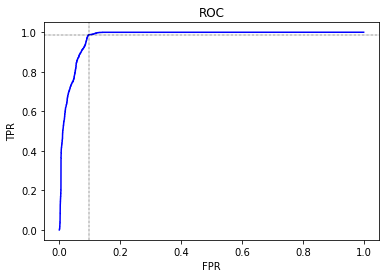

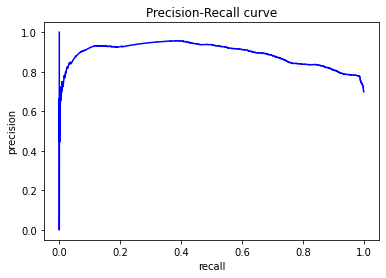

array([[9701, 1035],
       [  48, 3586]], dtype=int64)

Accuracy: 0.925
Precision: 0.776
Recall: 0.987
F1: 0.869


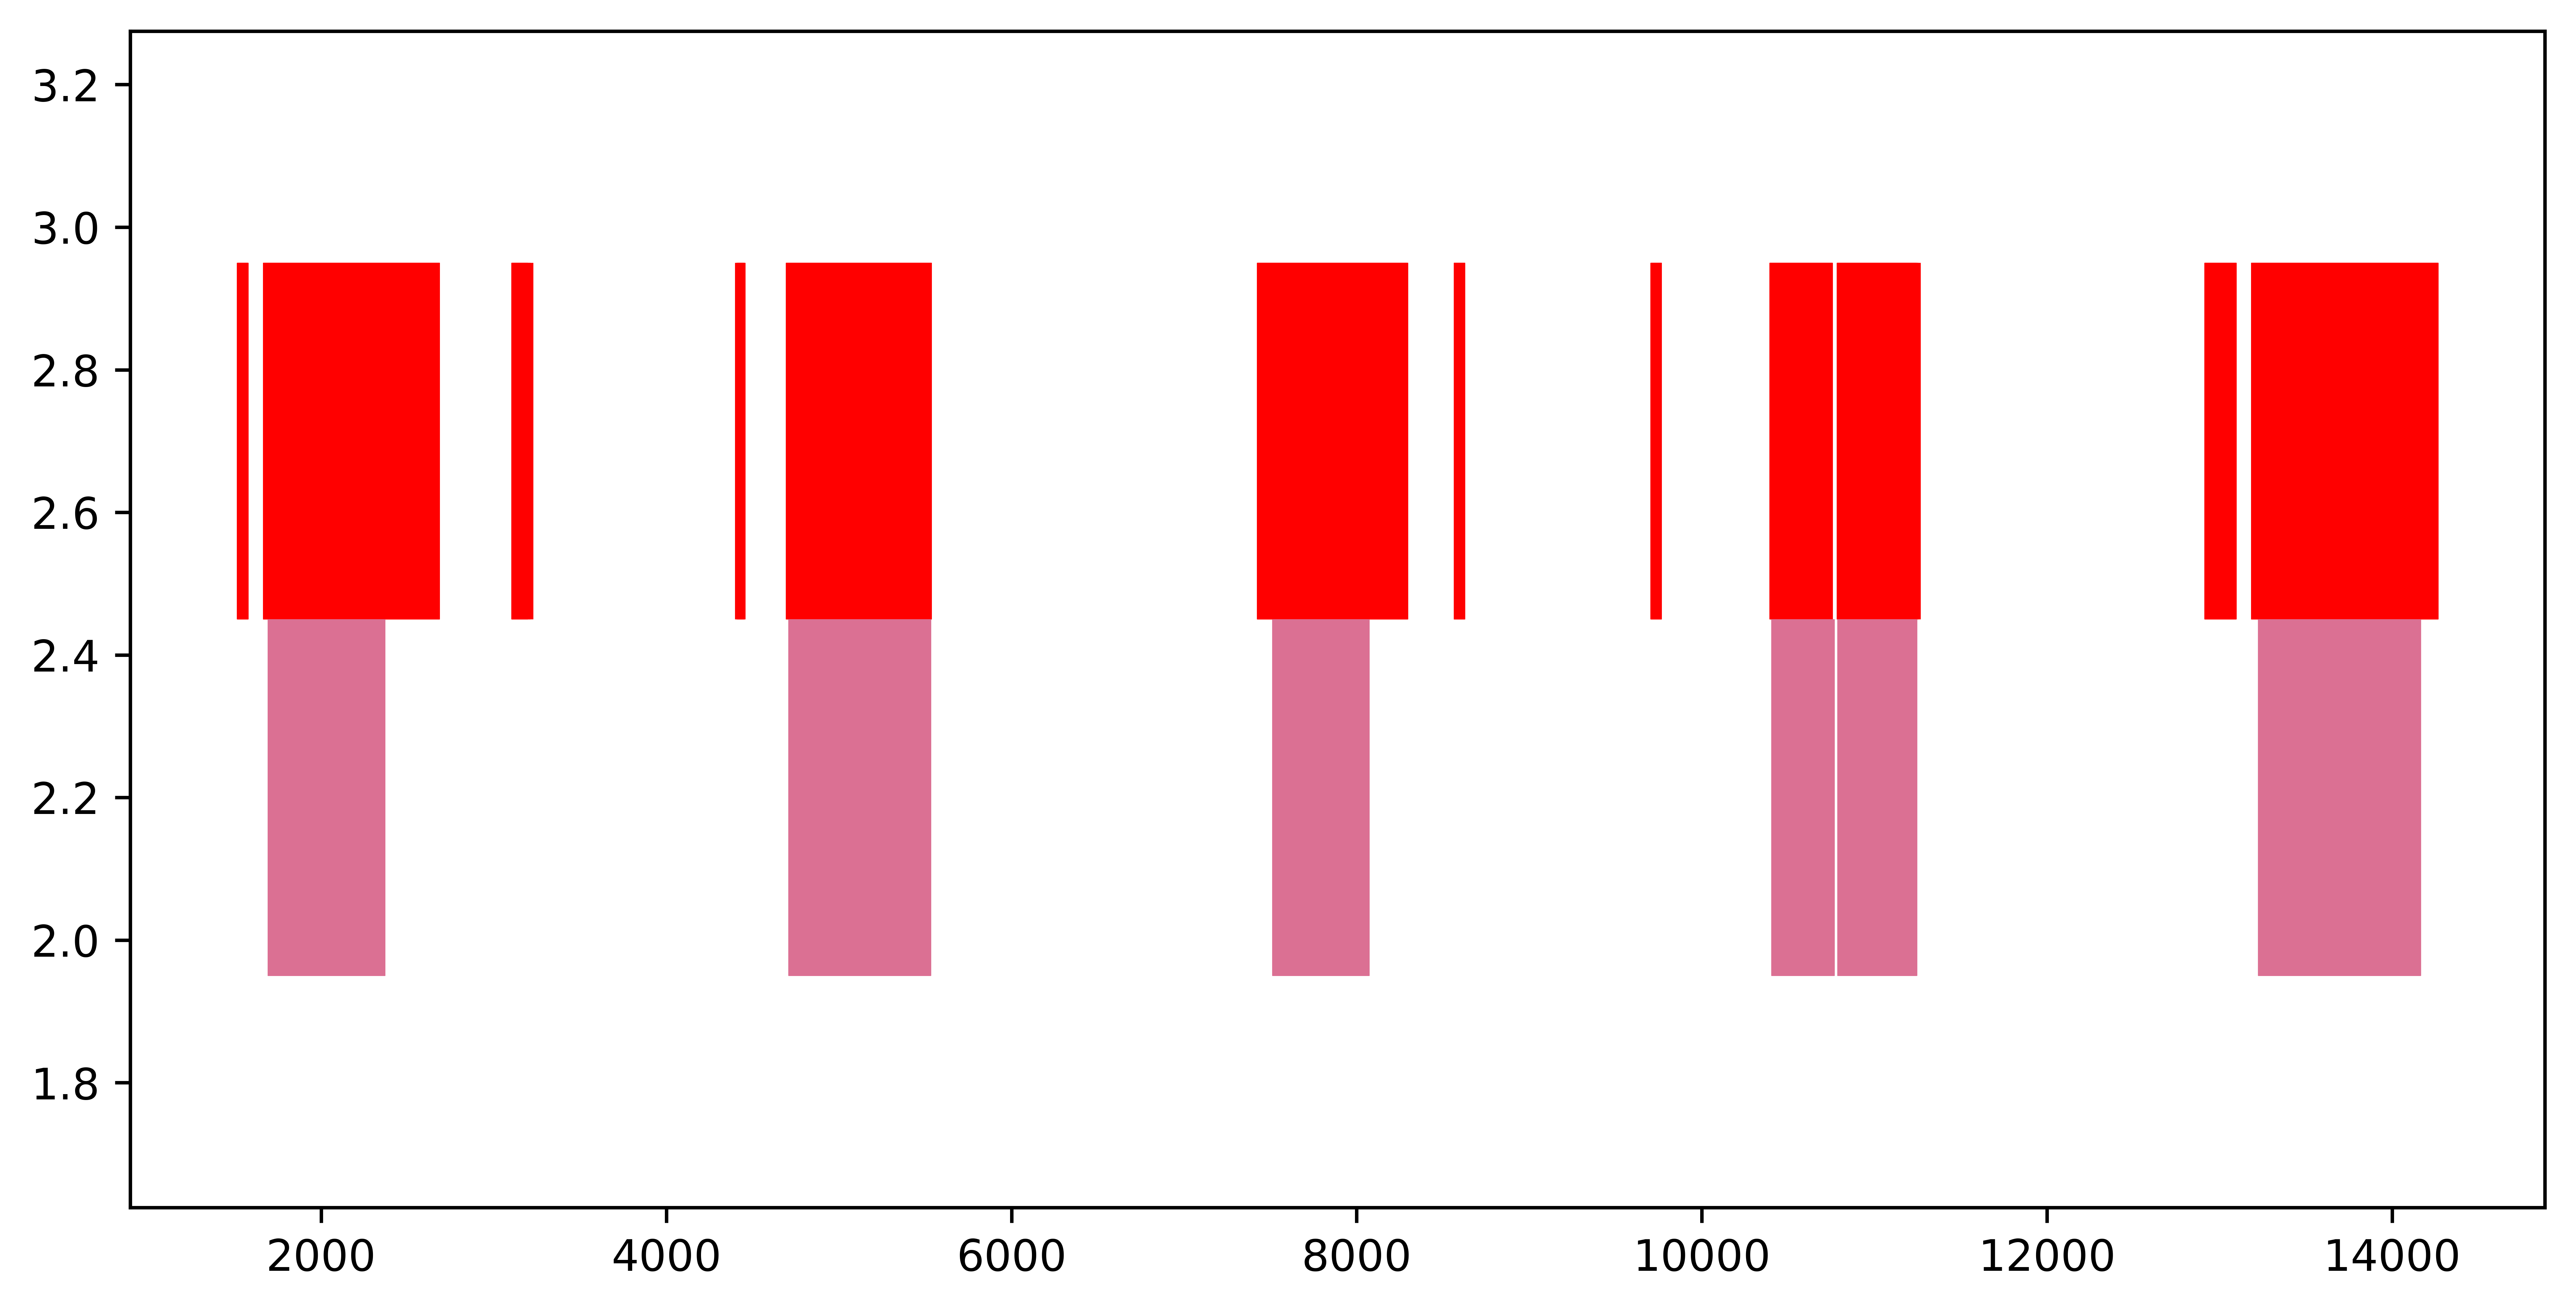

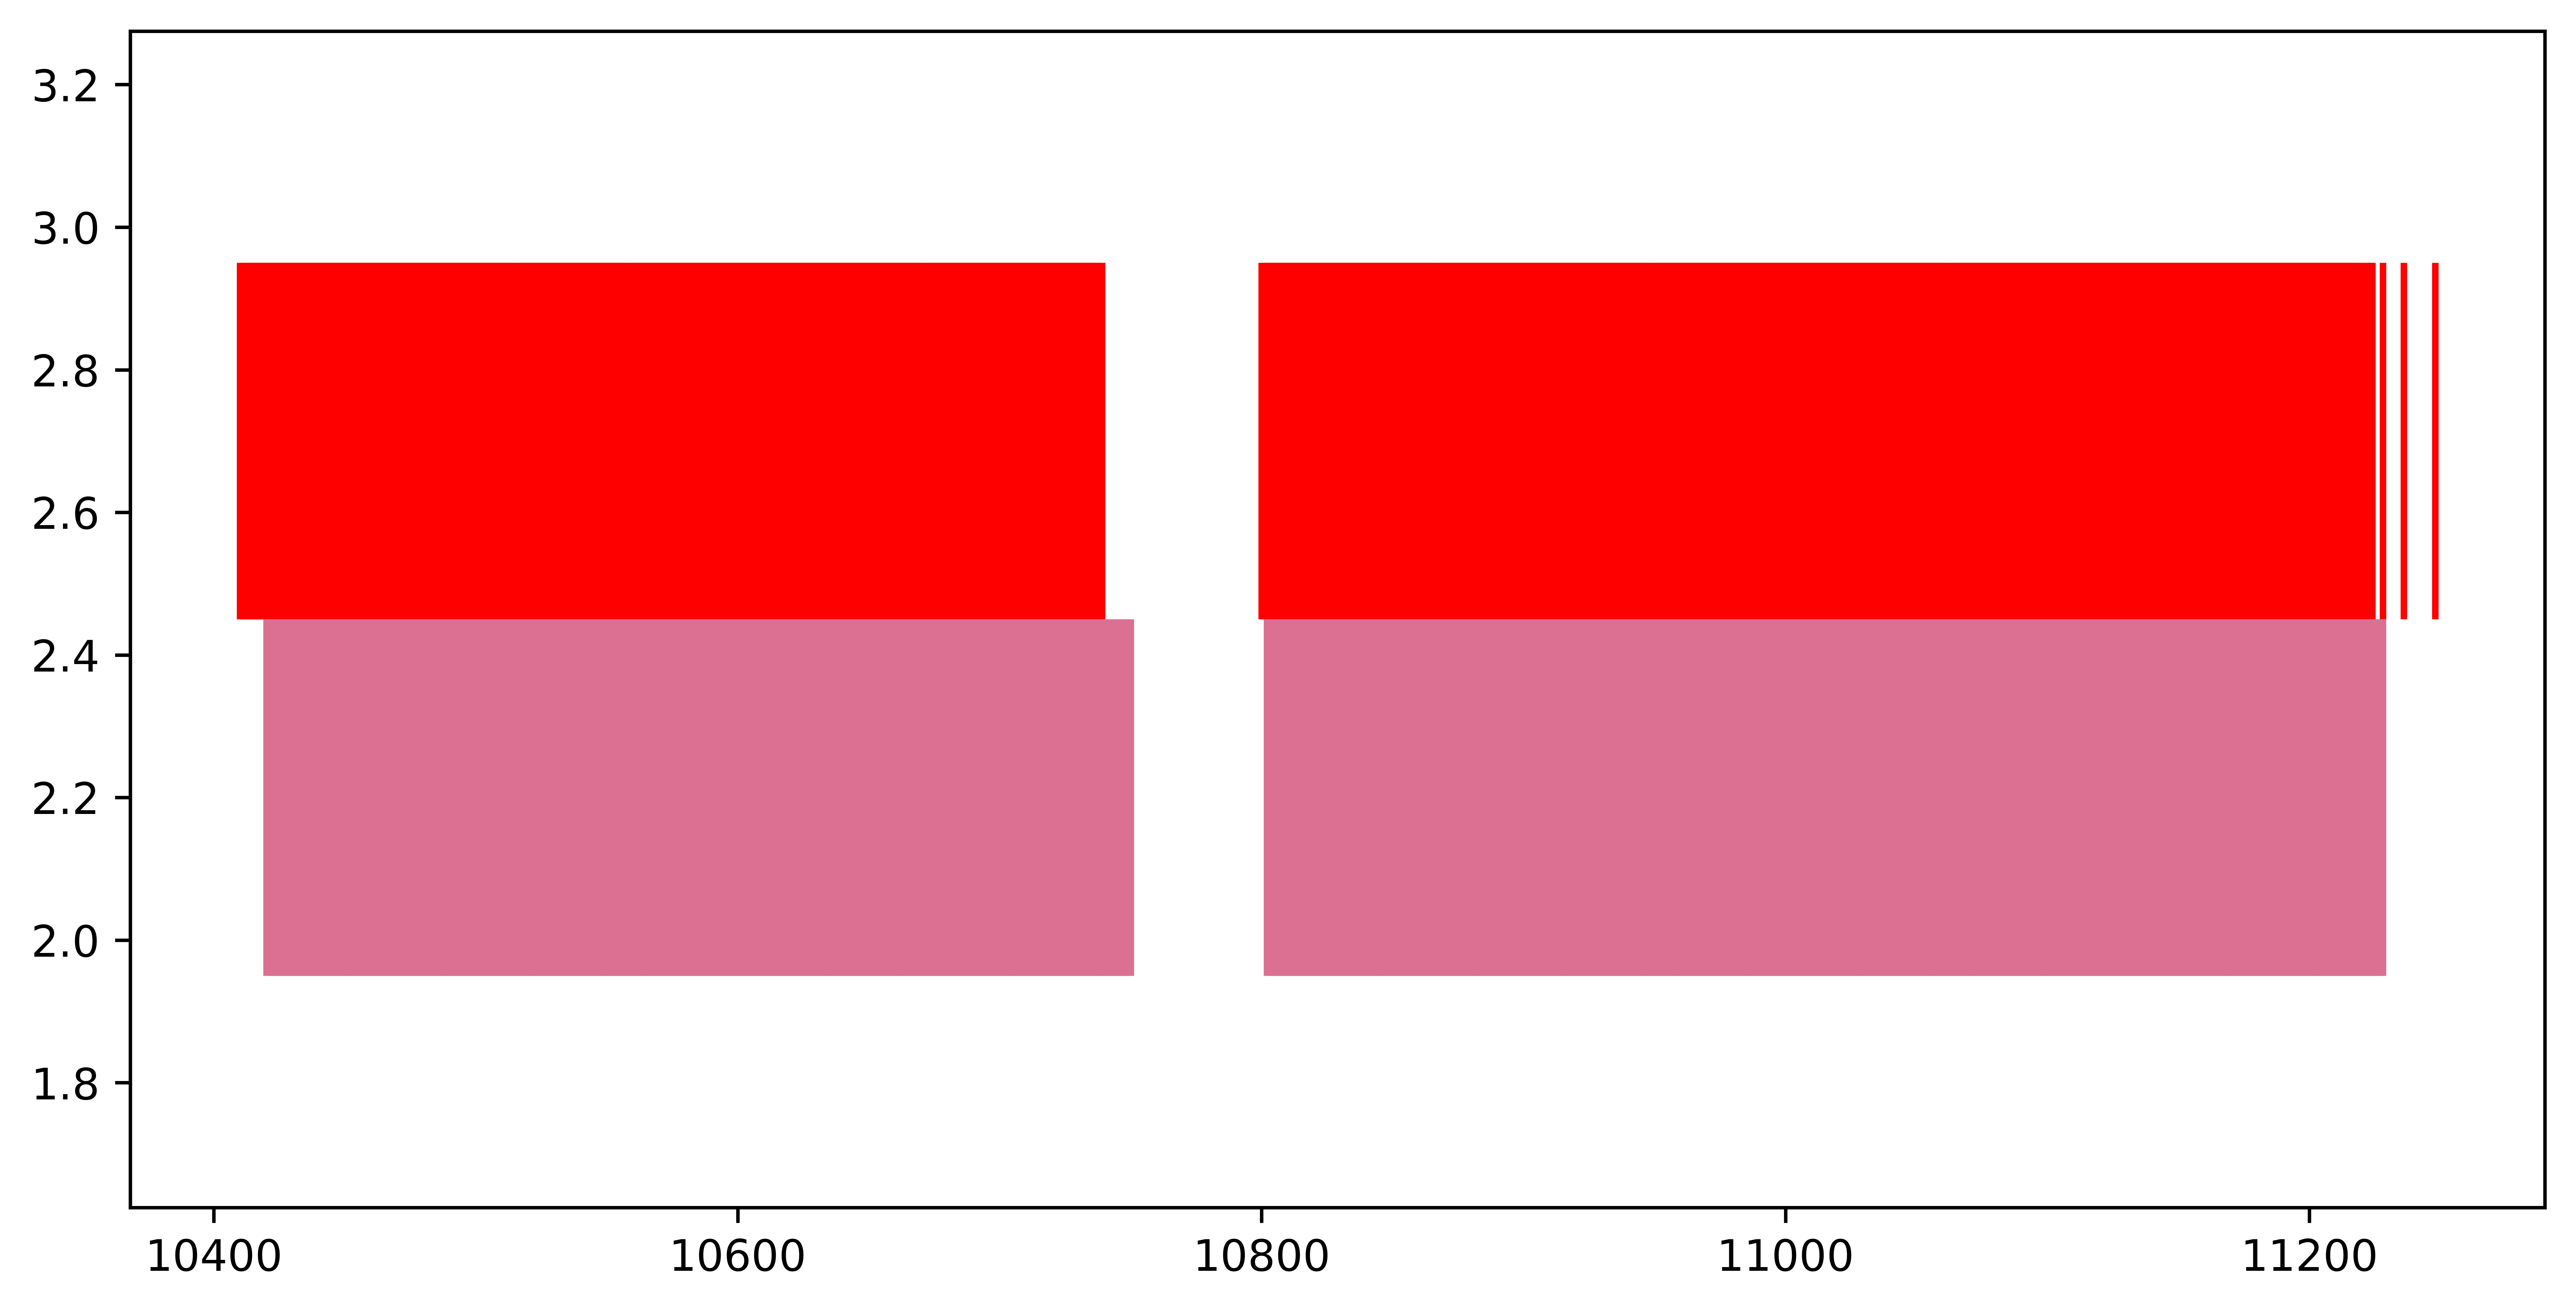

In [160]:
print(test_users)

pred = rs.best_estimator_.model.predict(test_x)
pred = pred.flatten()
true = test_y.flatten()
print(pred.shape)
print(type(true[0]))

from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(true, pred)

# geometric mean(G-mean) of sensitivity and specificity.
gmean = np.sqrt(tpr * (1 - fpr))
# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(threshold[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))



plt.plot(fpr, tpr, 'b')
plt.axhline(y=tpr[index], color='black', linestyle='-.', linewidth=0.4)
plt.axvline(x=fpr[index], color='black', linestyle='-.', linewidth=0.4)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.show()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(true, pred)
plt.plot(recall, precision, 'b')
plt.title('Precision-Recall curve')
plt.xlabel('recall')
plt.ylabel('precision')

plt.show()


pred = (pred > thresholdOpt).astype(float)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true, pred)
display(cm)
accuracy = (cm[1,1] + cm[0,0]) / (cm[1,1] + cm[0,0] + cm[0,1] + cm[1,0])
precision = (cm[1,1]) / (cm[1,1] + cm[0,1] + 1e-16)
recall = (cm[1,1]) / (cm[1,1] + cm[1,0] + 1e-16)
f1 = (2 * precision * recall) / (precision + recall + 1e-16)

print('Accuracy:', round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1:', round(f1, 3))

pred = np.arange(0,pred.shape[0]) * pred
pred = pred[pred>0]
true = np.arange(0,true.shape[0]) * true
true = true[true>0]


fig = plt.figure(figsize=(10,5), dpi=1000)
ax = fig.add_subplot(111)
ax.eventplot(pred, lineoffsets=[2.7], linelengths=[0.5], colors='r')
ax.eventplot(true, lineoffsets=[2.2], linelengths=[0.5], colors='palevioletred')
plt.show()

fig2 = plt.figure(figsize=(10,5), dpi=1000)
ax2 = fig2.add_subplot(111)
ax2.eventplot(pred[(pred>10000)&(pred<12000)], lineoffsets=[2.7], linelengths=[0.5], colors='r')
ax2.eventplot(true[(true>10000)&(true<12000)], lineoffsets=[2.2], linelengths=[0.5], colors='palevioletred')
plt.show()

